How do nanoscale and mesoscale properties of precision fermentation-derived caseins (nonmicellar casein) in a mixed gel with pea proteins influence the rheological properties of gels? 

Introduction

In this project, I make use of data science techniques to explore the relationship between nanoscale and mesoscale properties of gels and their rheological behavior. By applying multilinear regression, neural networks, and clustering to simulated data, I aim to uncover patterns that bridge the microscopic structure of gels with their macroscopic flow properties.

This project serves as both a technical demonstration and a scientific exploration. From a data science perspective, it highlights and serves as a learning opportunity to grow my ability to build and evaluate predictive models, apply machine learning techniques, and extract meaningful insights from complex datasets. From a food science perspective, it demonstrates my understanding of gel systems, rheology, and the interplay between structure and functionality. Ultimately, it is an expression of my passion for food science and the new frontiers that are being explored through new interdisciplinary methods.

Step 1: Obtaining Data

Due to difficulties in obtaining suitable datasets, a dataset will be simulated. 

This will include data that can be used to perform a multilinear regression, neural network, and clustering analysis of the impact of several different variables on gel characteristics. The properties range from nanoscale and mesoscale properties to macroscopic properties. 

Nanoscale Properties:

Zeta Potential (mV)

Particle Size Distribution (nm)

Hydrophobicity Index


Mesoscale Properties:

Protein Solubility (%)



Other variables:

Protein ratio (casein: pea protein)

pH 

Temperature

[GDL]) 


Macroscale properties:

Storage modulus (G')

Loss modulus (G")

Gel strength

Some notes on the data:

Particle size refers to protein aggregate size. The form of casein assumed to be used in this study is sodium caseinate (nonmicellar casein) for simplicity's sake as the incorporation of micellar casein or hybrid micelles, while of great interest, is beyond the scope here and a simple mixture where nonmicellar casein and pea protein interact is more applicable. GDL is the coagulant used as chymosin is not relevant for a nonmicellar casein. The pea protein and caseinate aggreggates are likely due to largely hydrophobic interactions (REF). 

The isoelectric point of casein is pH 4.6 and that of pea protein is (REF). This may affect the particle size as the two protein sources may coagulate at different times during acidification. Also, the rate of acidification is not data that is included here but which may be useful to explain some differences in aggregate size (and hence gel strength). 

The total protein content is unknown. This would be important information to have in a real-life setting. Direct comparisons to other protein gels cannot be made as the protein content should be known for this. Data on other factors such as ionic strength, syneresis, and aggregate morphology could also provide useful information on the gel properties. A sensory analysis, possibly combined with chromatography methods, of the resultant gels may be useful as well as the palatibility of pea protein is a known issue and may reduce the acceptability of hybrid products. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro


# Setting random seed for reproducibility
np.random.seed(42)

# Number of samples to simulate
n_samples = 500

# Simulating independent variables
pH = np.random.uniform(4.0, 7.0, n_samples)  # pH range from 4.0 (acidic) to 7.0 (neutral)
protein_ratio = np.random.choice(["20:80", "50:50", "80:20"], size=n_samples, replace=True)  # Casein:Pea ratios
GDL_concentration = np.random.uniform(0.1, 1.0, n_samples)  # GDL concentration in %
temperature = np.random.uniform(20, 60, n_samples)  # Temperature in °C

# Simulating nanoscale properties
zeta_potential = np.random.uniform(-40, -10, n_samples)  # mV, indicative of stability
particle_size = np.random.normal(150, 50, n_samples)  # nm, aggregation size
hydrophobicity = np.random.uniform(0.4, 0.9, n_samples)  # Hydrophobicity index
solubility = np.random.uniform(60, 95, n_samples)  # Protein solubility percentage

# Adding some noise to nanoscale properties to simulate variability
zeta_potential += np.random.normal(0, 5, n_samples)
particle_size += np.random.normal(0, 10, n_samples)
hydrophobicity += np.random.normal(0, 0.05, n_samples)
solubility += np.random.normal(0, 3, n_samples)

# Simulating macroscale rheological properties (dependent variables)
# Using a combination of nanoscale properties, pH, and other factors to generate dependent variables
storage_modulus = (
    200 + 50 * (7 - pH) + 20 * (GDL_concentration) +
    0.8 * zeta_potential + 0.5 * solubility +
    np.random.normal(0, 20, n_samples)
)  # Elasticity in Pa

loss_modulus = (
    50 + 10 * (7 - pH) + 15 * (GDL_concentration) +
    0.4 * zeta_potential + 0.3 * solubility +
    np.random.normal(0, 10, n_samples)
)  # Viscosity in Pa

gel_strength = (
    10 + 5 * (7 - pH) + 3 * GDL_concentration +
    0.6 * particle_size + 0.8 * hydrophobicity +
    np.random.normal(0, 5, n_samples)
)  # Gel strength in g/cm²

# Creating the dataset
data = pd.DataFrame({
    "pH": pH,
    "Protein Ratio": protein_ratio,
    "GDL Concentration (%)": GDL_concentration,
    "Temperature (°C)": temperature,
    "Zeta Potential (mV)": zeta_potential,
    "Particle Size (nm)": particle_size,
    "Hydrophobicity Index": hydrophobicity,
    "Solubility (%)": solubility,
    "Storage Modulus (G')": storage_modulus,
    "Loss Modulus (G'')": loss_modulus,
    "Gel Strength (g/cm²)": gel_strength
})

# Adding missing values to simulate real-world dataset imperfections
for col in data.columns:
    data.loc[data.sample(frac=0.05).index, col] = np.nan  # 5% missing values per column

# Adding outliers to simulate experimental errors
outlier_indices = data.sample(frac=0.02).index  # 2% of the data
data.loc[outlier_indices, ["Storage Modulus (G')", "Loss Modulus (G'')"]] *= 3

# Save the dataset to a CSV file
data.to_csv("simulated_casein_pea_gel_dataset.csv", index=False)

print("Dataset successfully saved as 'simulated_casein_pea_gel_dataset.csv'.")


Dataset successfully saved as 'simulated_casein_pea_gel_dataset.csv'.


In [2]:
import pandas as pd

raw_data =  pd.read_csv(r"D:\OneDrive\Desktop\Job search\Project\simulated_casein_pea_gel_dataset.csv")

def dataset_summary(raw_data):
    print("Head of the Dataset:")
    print(raw_data.head())
    
    print("\nColumns and Details:")
    summary = {
        'Number of Rows': len(raw_data),
        'Number of Columns': raw_data.shape[1],
        'Missing Values': raw_data.isnull().sum(),
        'Unique Values': raw_data.nunique(),
        'Data Types': raw_data.dtypes
    }
    
    print("\nMissing Values per Column:")
    print(summary['Missing Values'].to_frame(name="Missing Values"))
    
    print("\nUnique Values per Column:")
    print(summary['Unique Values'].to_frame(name="Unique Values"))
    
    print("\nData Types:")
    print(summary['Data Types'].to_frame(name="Data Type"))
    
    print("\nBasic Statistics:")
    print(raw_data.describe())

dataset_summary(raw_data)


Head of the Dataset:
         pH Protein Ratio  GDL Concentration (%)  Temperature (°C)  \
0  5.123620      50:50:00               0.459102         49.263581   
1  6.852143      80:20:00               0.149285         23.265199   
2  6.195982   0.888888889               0.401678         22.414083   
3  5.795975           NaN               0.822568         29.884129   
4  4.468056   0.888888889               0.104169         26.381787   

   Zeta Potential (mV)  Particle Size (nm)  Hydrophobicity Index  \
0           -15.201384           76.101269              0.584558   
1           -21.631936           42.919799              0.585339   
2           -37.210943          183.234514              0.423603   
3           -32.124619          134.543314              0.709024   
4           -41.455938          189.695154              0.773202   

   Solubility (%)  Storage Modulus (G')  Loss Modulus (G'')  \
0       67.955590            334.484215           82.191093   
1       58.952025      

In [3]:
df = pd.DataFrame(raw_data)

# Convert non-null values to strings, keeping NaNs 
df['Protein Ratio'] = df['Protein Ratio'].apply(lambda x: str(x) if pd.notna(x) else pd.NA)

# Replace incorrect values
df['Protein Ratio'] = df['Protein Ratio'].replace({
    '50:50:00': '50:50',  
    '80:20:00': '80:20',
    '0.888888889': '20:80',  
    })
print(df['Protein Ratio'].apply(type).unique())
print(df['Protein Ratio'].isna().sum()) 
print(df.head())

[<class 'str'> <class 'pandas._libs.missing.NAType'>]
25
         pH Protein Ratio  GDL Concentration (%)  Temperature (°C)  \
0  5.123620         50:50               0.459102         49.263581   
1  6.852143         80:20               0.149285         23.265199   
2  6.195982         20:80               0.401678         22.414083   
3  5.795975          <NA>               0.822568         29.884129   
4  4.468056         20:80               0.104169         26.381787   

   Zeta Potential (mV)  Particle Size (nm)  Hydrophobicity Index  \
0           -15.201384           76.101269              0.584558   
1           -21.631936           42.919799              0.585339   
2           -37.210943          183.234514              0.423603   
3           -32.124619          134.543314              0.709024   
4           -41.455938          189.695154              0.773202   

   Solubility (%)  Storage Modulus (G')  Loss Modulus (G'')  \
0       67.955590            334.484215           

Determining if outliers are present:

The thresholds used to determine if outliers are present

Lower Bound = Q1 - (1.5 * IQR)

Upper Bound = Q3 + (1.5 * IQR)

IQR values for each column:
pH: 1.546082436999999
GDL Concentration (%): 0.478779771
Temperature (°C): 19.941907465
Zeta Potential (mV): 14.131750310000001
Particle Size (nm): 72.12376894999998
Hydrophobicity Index: 0.2527147475
Solubility (%): 17.99541291
Storage Modulus (G'): 85.00191390000003
Loss Modulus (G''): 20.70122427999999
Gel Strength (g/cm²): 44.26093498

Outliers in pH:
Empty DataFrame
Columns: [pH, Protein Ratio, GDL Concentration (%), Temperature (°C), Zeta Potential (mV), Particle Size (nm), Hydrophobicity Index, Solubility (%), Storage Modulus (G'), Loss Modulus (G''), Gel Strength (g/cm²)]
Index: []

Outliers in GDL Concentration (%):
Empty DataFrame
Columns: [pH, Protein Ratio, GDL Concentration (%), Temperature (°C), Zeta Potential (mV), Particle Size (nm), Hydrophobicity Index, Solubility (%), Storage Modulus (G'), Loss Modulus (G''), Gel Strength (g/cm²)]
Index: []

Outliers in Temperature (°C):
Empty DataFrame
Columns: [pH, Protein Ratio, GDL Concentration (%), T

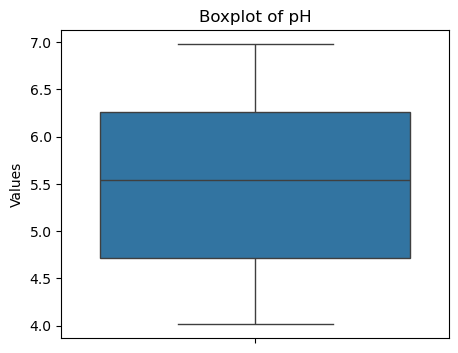

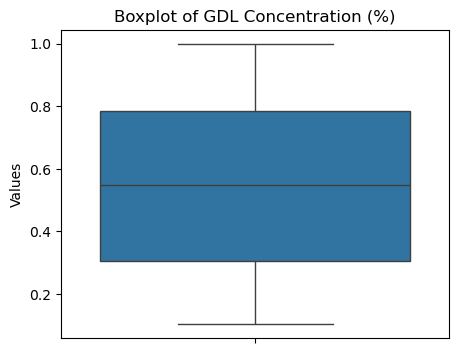

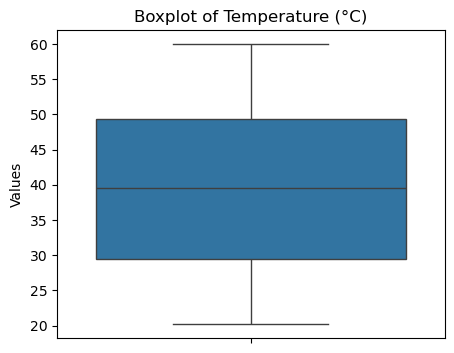

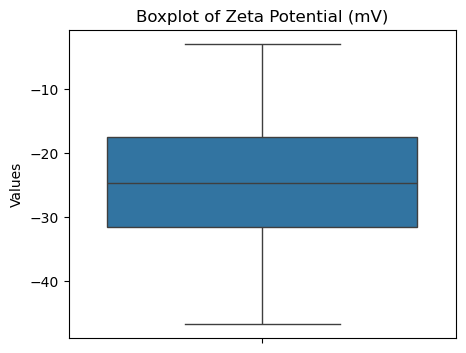

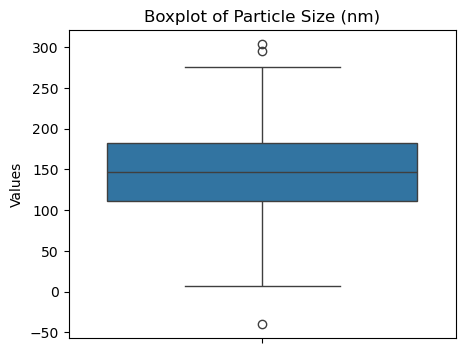

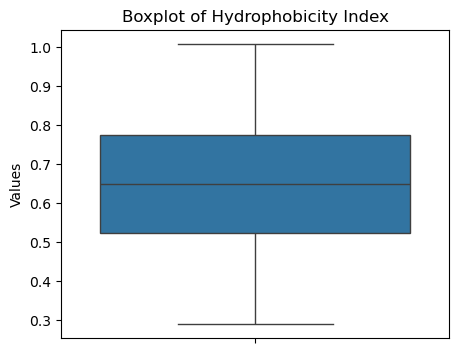

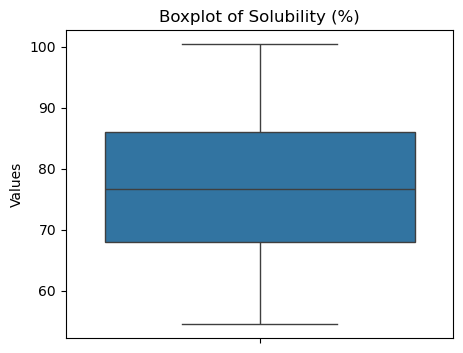

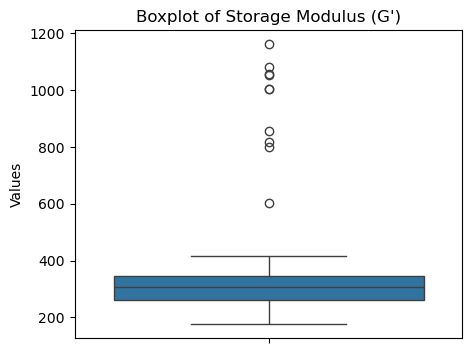

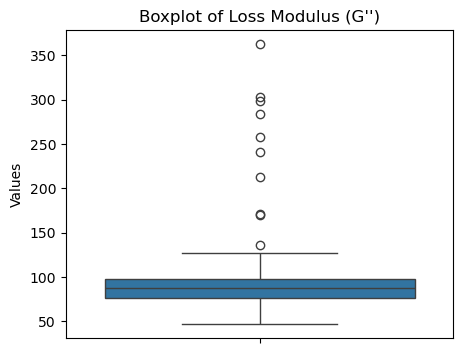

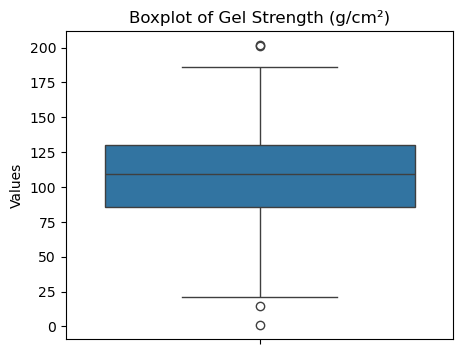

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate IQR and detect outliers
def calculate_iqr(dataframe):
    iqr_values = {}
    lower_bounds = {}
    upper_bounds = {}
    outliers = {}

    for column in dataframe.select_dtypes(include='number').columns:
        q1 = dataframe[column].quantile(0.25)  # 25th percentile
        q3 = dataframe[column].quantile(0.75)  # 75th percentile
        iqr = q3 - q1

        # Store IQR values
        iqr_values[column] = iqr

        # Calculate outlier thresholds
        lower_bounds[column] = q1 - (1.5 * iqr)
        upper_bounds[column] = q3 + (1.5 * iqr)

        # Identify outliers
        outliers[column] = dataframe[(dataframe[column] < lower_bounds[column]) | (dataframe[column] > upper_bounds[column])]

    return iqr_values, lower_bounds, upper_bounds, outliers

# Compute IQR and outliers
iqr_results, lower_bounds, upper_bounds, outliers = calculate_iqr(df)

# Print IQR values
print("IQR values for each column:")
for column, iqr in iqr_results.items():
    print(f"{column}: {iqr}")

# Print outliers
for column, outlier_df in outliers.items():
    print(f"\nOutliers in {column}:")
    print(outlier_df)

# Create individual boxplots for each column
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(5, 4))  # Set figure size for each plot
    sns.boxplot(y=df[column])
    
    # Customizing the plot
    plt.title(f"Boxplot of {column}")
    plt.ylabel("Values")

    # Show each individual plot
    plt.show()


Dealing with missing protein ratio values:

In [5]:
df_no_missing_pr = df[df['Protein Ratio'].notna()]
print(df_no_missing_pr['Protein Ratio'].tolist())

['50:50', '80:20', '20:80', '20:80', '20:80', '20:80', '20:80', '20:80', '50:50', '80:20', '20:80', '50:50', '50:50', '80:20', '20:80', '80:20', '20:80', '50:50', '50:50', '50:50', '50:50', '80:20', '20:80', '20:80', '80:20', '20:80', '50:50', '20:80', '50:50', '80:20', '20:80', '80:20', '20:80', '80:20', '20:80', '50:50', '80:20', '80:20', '20:80', '20:80', '20:80', '50:50', '20:80', '80:20', '80:20', '20:80', '80:20', '50:50', '20:80', '20:80', '80:20', '20:80', '50:50', '80:20', '20:80', '80:20', '20:80', '20:80', '20:80', '50:50', '50:50', '80:20', '20:80', '20:80', '50:50', '20:80', '50:50', '20:80', '80:20', '20:80', '20:80', '20:80', '20:80', '50:50', '80:20', '80:20', '50:50', '50:50', '50:50', '50:50', '80:20', '80:20', '50:50', '20:80', '50:50', '20:80', '50:50', '50:50', '80:20', '20:80', '20:80', '80:20', '80:20', '80:20', '80:20', '20:80', '20:80', '50:50', '50:50', '80:20', '80:20', '80:20', '50:50', '50:50', '50:50', '50:50', '50:50', '50:50', '50:50', '80:20', '80:20', 

Determining whether to impute missing data with median or mean:

Columns that contain outliers (where NaN values will be imputed using the median): Particle Size, Storage Modulus (G'), Loss Modulus (G"), Gel Strength. 

Columns that do not contain outliers (where NaN values will be imputed using the mean): pH, GDL Concentration, Temperature, Zeta Potential, Hydrophobicity Index, Solubility
    

In [6]:
#rename columns to avoid conflicting instructions in code due to quotation marks
df_no_missing_pr = df_no_missing_pr.rename(columns={
    "Storage Modulus (G')": "Storage Modulus (Gʹ)",
    "Loss Modulus (G'')": "Loss Modulus (Gʺ)"
})

print(df_no_missing_pr.columns)

Index(['pH', 'Protein Ratio', 'GDL Concentration (%)', 'Temperature (°C)',
       'Zeta Potential (mV)', 'Particle Size (nm)', 'Hydrophobicity Index',
       'Solubility (%)', 'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)',
       'Gel Strength (g/cm²)'],
      dtype='object')


In [7]:
# Fill columns with outliers using their median values
df_no_missing_pr.loc[:, ['Particle Size (nm)', 'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)', 'Gel Strength (g/cm²)']] = \
    df_no_missing_pr[['Particle Size (nm)', 'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)', 'Gel Strength (g/cm²)']].fillna(
        df_no_missing_pr[['Particle Size (nm)', 'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)', 'Gel Strength (g/cm²)']].median()
    )

# Fill columns without outliers using their mean values
df_no_missing_pr.loc[:, ['pH', 'GDL Concentration (%)', 'Temperature (°C)', 'Zeta Potential (mV)', 'Hydrophobicity Index', 'Solubility (%)']] = \
    df_no_missing_pr[['pH', 'GDL Concentration (%)', 'Temperature (°C)', 'Zeta Potential (mV)', 'Hydrophobicity Index', 'Solubility (%)']].fillna(
        df_no_missing_pr[['pH', 'GDL Concentration (%)', 'Temperature (°C)', 'Zeta Potential (mV)', 'Hydrophobicity Index', 'Solubility (%)']].mean()
    )

print(df_no_missing_pr.isnull().sum())

pH                       0
Protein Ratio            0
GDL Concentration (%)    0
Temperature (°C)         0
Zeta Potential (mV)      0
Particle Size (nm)       0
Hydrophobicity Index     0
Solubility (%)           0
Storage Modulus (Gʹ)     0
Loss Modulus (Gʺ)        0
Gel Strength (g/cm²)     0
dtype: int64


All missing values have been dealt with

In [8]:
df_no_missing_pr.to_csv(r"D:\OneDrive\Desktop\Job search\Project\clean_non_std.csv", index=False)

Converting protein ratios to integers

Protein ratios, currently in the form of casein: pea will be converted to the proportion of casein present i.e. the ratio 80:20 will be replaced by 0.8. While this removes any information about the pea protein specifically, it avoids collinearity issues as the amount of pea protein is implicit in the amount of casein present. 

In [9]:
# Replace ratios with integers
df_no_missing_pr['Protein Ratio'] = df_no_missing_pr['Protein Ratio'].replace({
    '50:50': '0.5',  
    '80:20': '0.8',
    '20:80': '0.2',  
    })
print(df_no_missing_pr['Protein Ratio'].apply(type).unique())
print(df_no_missing_pr['Protein Ratio'].isna().sum()) 
print(df_no_missing_pr['Protein Ratio'].head())

[<class 'str'>]
0
0    0.5
1    0.8
2    0.2
4    0.2
5    0.2
Name: Protein Ratio, dtype: object


In [10]:
df_clean = df_no_missing_pr

Normalisation of data

Normalisation will improve the accuracy of most machine learning models by ensuring that all variables are weighted on the same scale. Z-score standardisation is chosen as it preserves outliers. However, if the data does not follow a normal distribution, Z-score standardisation may not be appropriate. Also, as the original units are lost, the model can be more difficult to interpret. Hence, some exploratory data analysis should be performed in order to verify the distribution patterns of the data. A few different methods of ascertaining normality will be performed: histograms and Kernel Density Estimates (KDE) will be plotted for a visual inspection and Quantile-Quantile (Q-Q) plots will be plotted to compare the distribution of the variable to the normal distribution. These will be confirmed by a statistical test, the Shapiro- Wilk test (used for smaller datasets such as this). 

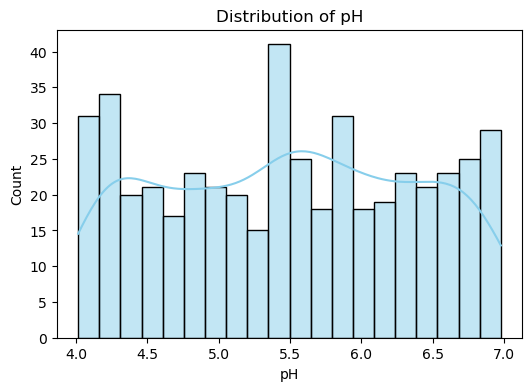

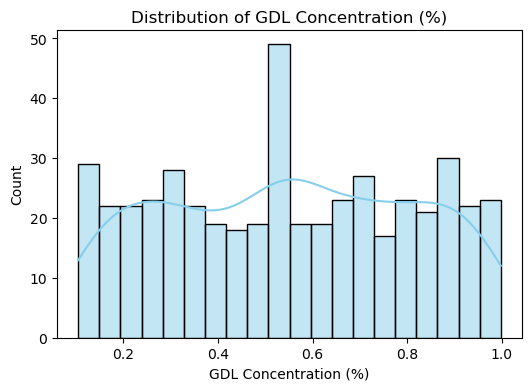

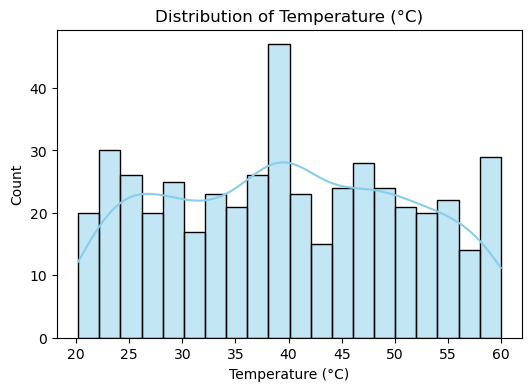

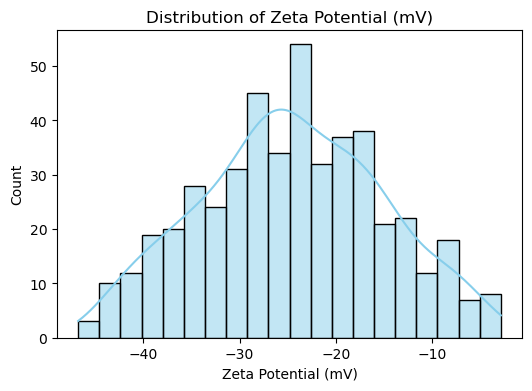

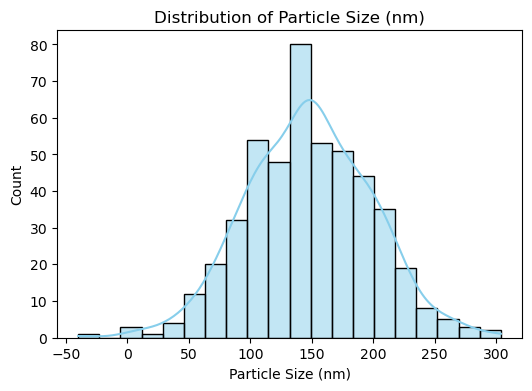

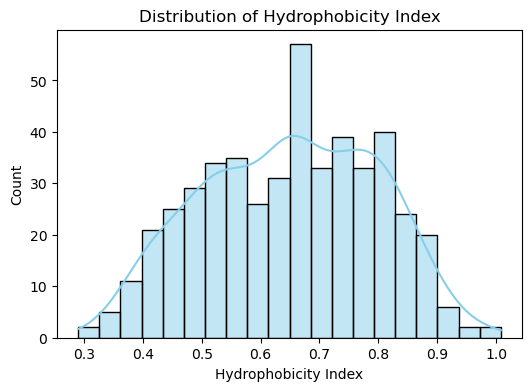

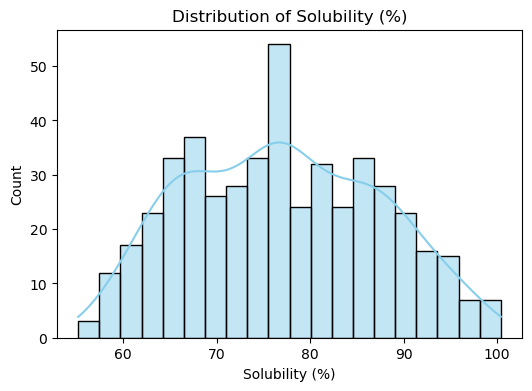

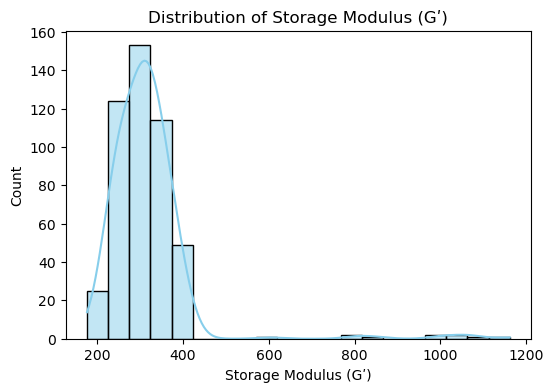

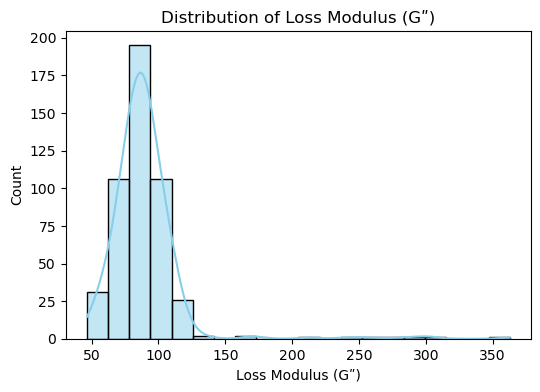

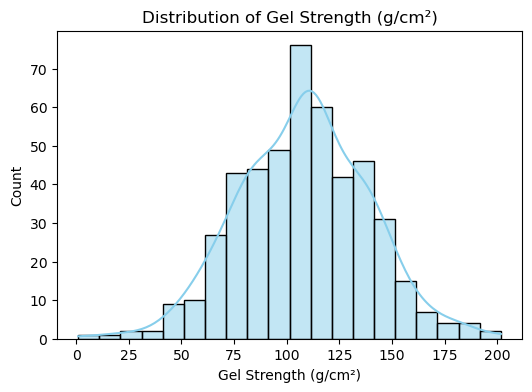

In [11]:
# Define dependent variables
dependent_vars = [
    'pH', 'GDL Concentration (%)', 'Temperature (°C)', 'Zeta Potential (mV)',
    'Particle Size (nm)', 'Hydrophobicity Index', 'Solubility (%)',
    'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)', 'Gel Strength (g/cm²)'
]

# Plot histograms and Kernel Density Estimates (KDE) for each variable
for var in dependent_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_clean[var], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of {var}')
    plt.show()

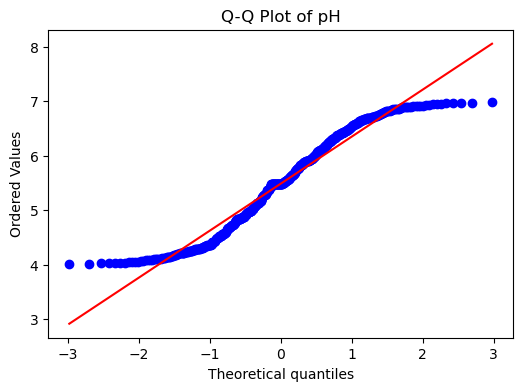

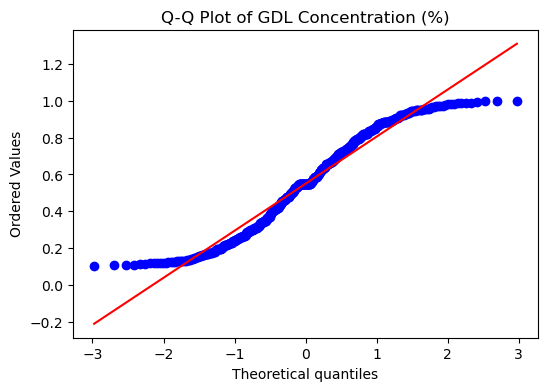

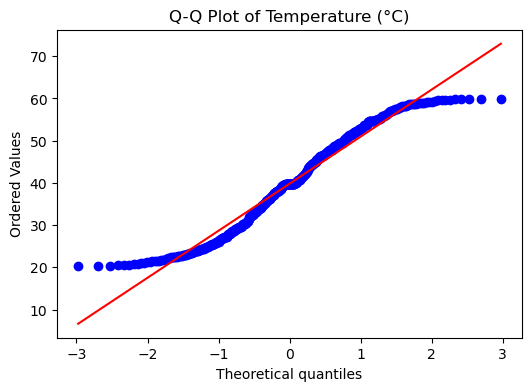

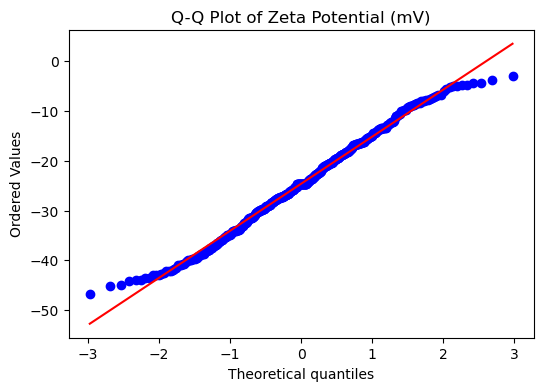

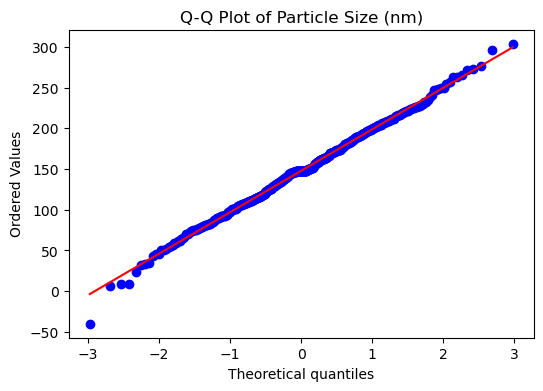

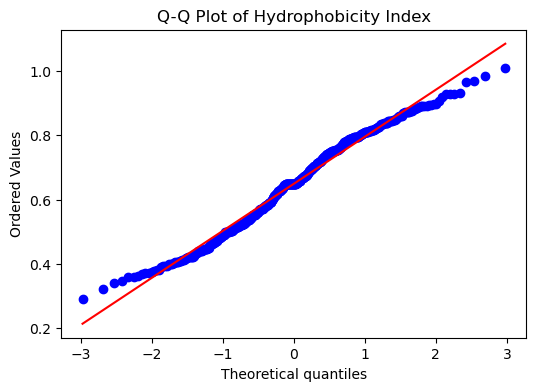

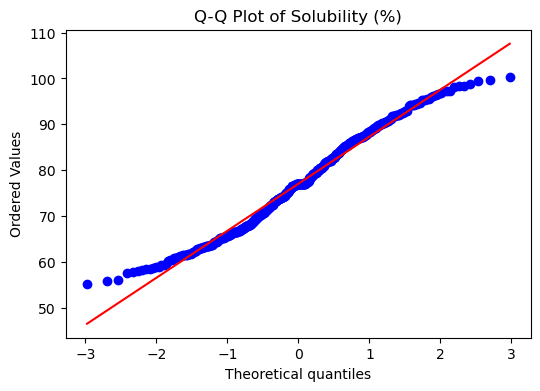

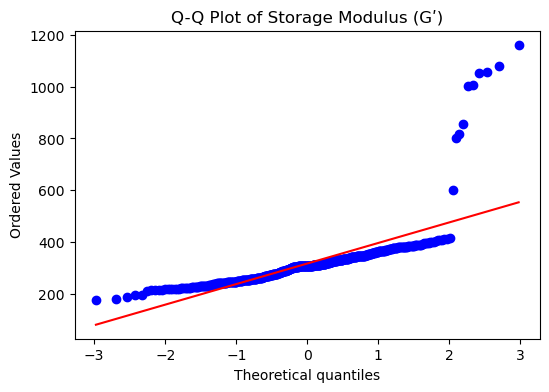

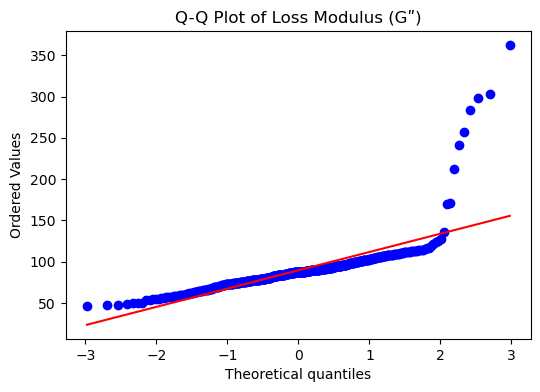

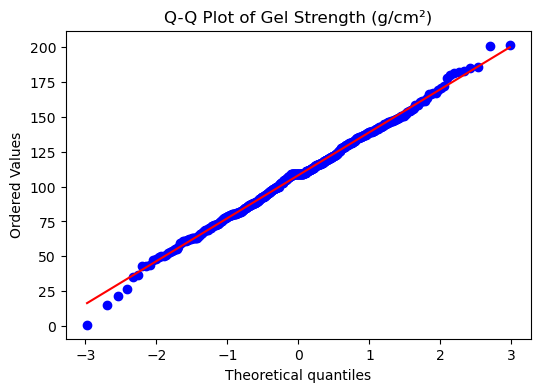

In [12]:
# Q-Q plot for each variable
for var in dependent_vars:
    plt.figure(figsize=(6, 4))
    stats.probplot(df_clean[var], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {var}')
    plt.show()

In [13]:
#Shapiro-Wilk test
for var in dependent_vars:
    stat, p = shapiro(df_clean[var].dropna())
    print(f'{var}: p-value = {p:.4f}')

#p > 0.05: Data is likely normal.
#p ≤ 0.05: Data is not normal.

pH: p-value = 0.0000
GDL Concentration (%): p-value = 0.0000
Temperature (°C): p-value = 0.0000
Zeta Potential (mV): p-value = 0.0064
Particle Size (nm): p-value = 0.7221
Hydrophobicity Index: p-value = 0.0000
Solubility (%): p-value = 0.0000
Storage Modulus (Gʹ): p-value = 0.0000
Loss Modulus (Gʺ): p-value = 0.0000
Gel Strength (g/cm²): p-value = 0.6200


Conclusions:

Only Particle Size and Gel Strength seem to be normally distributed. Z-score normalisation is not appropriate as it requires normally-distributed data. Instead of Z-score normalisation, a better approach may be to use Min-Max normalisation for the data used in the neural network and clustering models, while using Robust Scaler normalisation for the multilinear regression. The Min-Max normalisation is best suited to the neural network and clustering models as it retains outliers, does not assume a distribution, and contributes to faster convergence during training. Robust Scaler normalisation is better suited to the multilinear regression model as it de-emphasises outliers which can skew the coefficients and result in a less accurate model. Outliers are particularly problematic for linear models due to the Ordinary Least Squares method of finding the best life of fit as squared values have a disproportionate amount of influence on the results. 


*Note on the code that generated the variable values: the particle size data is the only variable with an explicitly normal distribution in the code. The distributions as described by the above analysis are consistent with their expected distributions. Gel properties are determined by linear combinations of the nanoscale and other properties and thus are dependent on these variables and the numerical coefficients for their ultimate distribution. As only the particle size is normally distributed, it is unsurprising that the storage and loss moduli are not normally distributed either, but the gel strength is normally distributed due to its reliance on particle size as one of its determinants. 

**Note on the applicability of the simulated data: in a real-life scenario, the GDL concentration and temperature are more likely to be controlled and not randomly assigned values. They could thus be of use as independent variables that could affect the gel properties, but this is beyond the scope of this current study where the protein ratio is the main focus. 

In [14]:
# Copying the dataframe into separate dataframes for multilinear regression and neural network and clustering models
df_multilin = df_clean.copy()
df_NN_K = df_clean.copy()

In [15]:
from sklearn.preprocessing import RobustScaler

# RobustScaler for df_multilin
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_multilin)
df_multilin = pd.DataFrame(scaled_data, columns=df_multilin.columns, index=df_multilin.index)

from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler for df_NN_K
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_NN_K)
df_NN_K = pd.DataFrame(normalized_data, columns=df_NN_K.columns, index=df_NN_K.index)

In [16]:
#Veryifying normalisation of dataframes
print(df_multilin.describe())

                 pH  Protein Ratio  GDL Concentration (%)  Temperature (°C)  \
count  4.750000e+02   4.750000e+02           4.750000e+02      4.750000e+02   
mean  -1.421085e-16   2.243819e-17          -1.009719e-16     -1.421085e-16   
std    5.806113e-01   4.095382e-01           5.742639e-01      5.891880e-01   
min   -9.693779e-01  -5.000000e-01          -9.830097e-01     -1.021871e+00   
25%   -4.987822e-01  -5.000000e-01          -5.146660e-01     -5.204194e-01   
50%    0.000000e+00   0.000000e+00           0.000000e+00      0.000000e+00   
75%    5.012178e-01   5.000000e-01           4.853340e-01      4.795806e-01   
max    9.843175e-01   5.000000e-01           9.900528e-01      1.052363e+00   

       Zeta Potential (mV)  Particle Size (nm)  Hydrophobicity Index  \
count         4.750000e+02          475.000000          4.750000e+02   
mean          1.738960e-16            0.010258          8.601307e-17   
std           7.117937e-01            0.727887          6.226798e-01   


In [17]:
print(df_NN_K.describe())

               pH  Protein Ratio  GDL Concentration (%)  Temperature (°C)  \
count  475.000000     475.000000             475.000000        475.000000   
mean     0.496177       0.500000               0.498215          0.492650   
std      0.297186       0.409538               0.291052          0.284051   
min      0.000000       0.000000               0.000000          0.000000   
25%      0.240875       0.000000               0.237369          0.241753   
50%      0.496177       0.500000               0.498215          0.492650   
75%      0.752725       1.000000               0.744195          0.723858   
max      1.000000       1.000000               1.000000          1.000000   

       Zeta Potential (mV)  Particle Size (nm)  Hydrophobicity Index  \
count           475.000000          475.000000            475.000000   
mean              0.504989            0.546378              0.500144   
std               0.215384            0.147558              0.204268   
min               

Normalisation was succesful. As expected, the Robust Scaler normalisation resulted in a median (50% percentile) of 0 and the Min-Max normalisation data all have minimums of 0 and maximums of 1. 

The models can be built after double-checking that the data is clean, if any feature selection needs to take place, and splitting the data into training and testing sets.

Multilinear regression: check for linear relationship between the features and the target and check for collinearity.

Neural network: Neural networks need sufficient data. Feature engineering can improve the model by inlcuding interaction terms or polynomial features if relationships are nonlinear.

In [18]:
#double-check for missing values
print(df_multilin.isna().sum())
print(df_NN_K.isna().sum())

pH                       0
Protein Ratio            0
GDL Concentration (%)    0
Temperature (°C)         0
Zeta Potential (mV)      0
Particle Size (nm)       0
Hydrophobicity Index     0
Solubility (%)           0
Storage Modulus (Gʹ)     0
Loss Modulus (Gʺ)        0
Gel Strength (g/cm²)     0
dtype: int64
pH                       0
Protein Ratio            0
GDL Concentration (%)    0
Temperature (°C)         0
Zeta Potential (mV)      0
Particle Size (nm)       0
Hydrophobicity Index     0
Solubility (%)           0
Storage Modulus (Gʹ)     0
Loss Modulus (Gʺ)        0
Gel Strength (g/cm²)     0
dtype: int64


Model 1: multilinear regression

Checking for linearity and collinearity

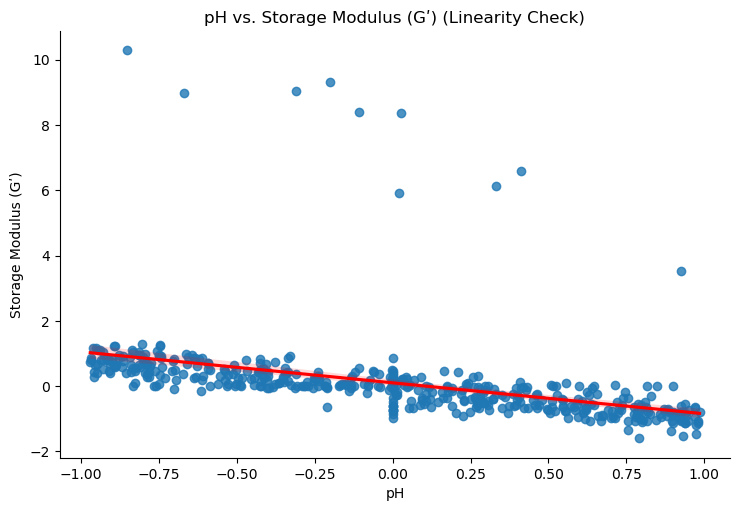

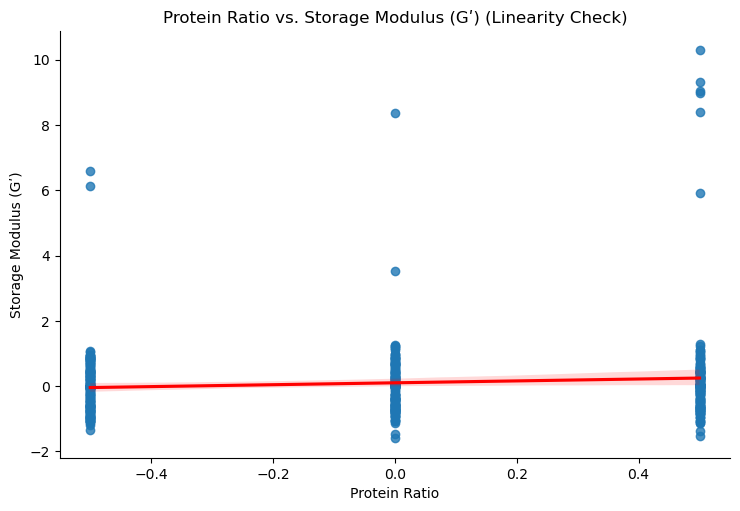

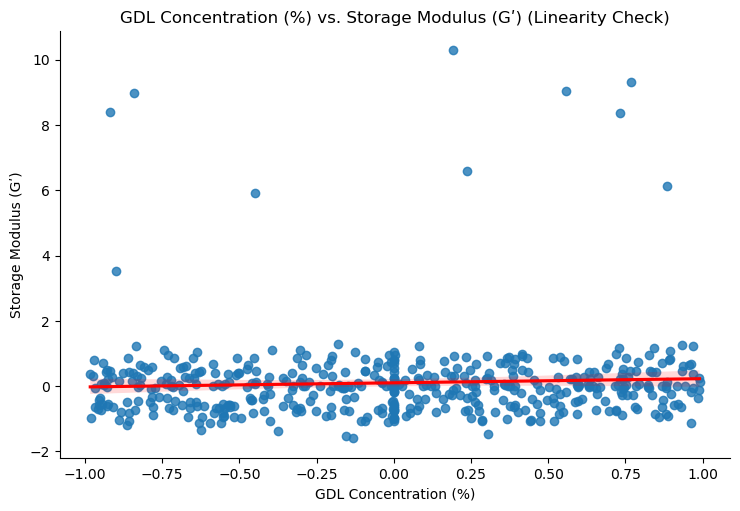

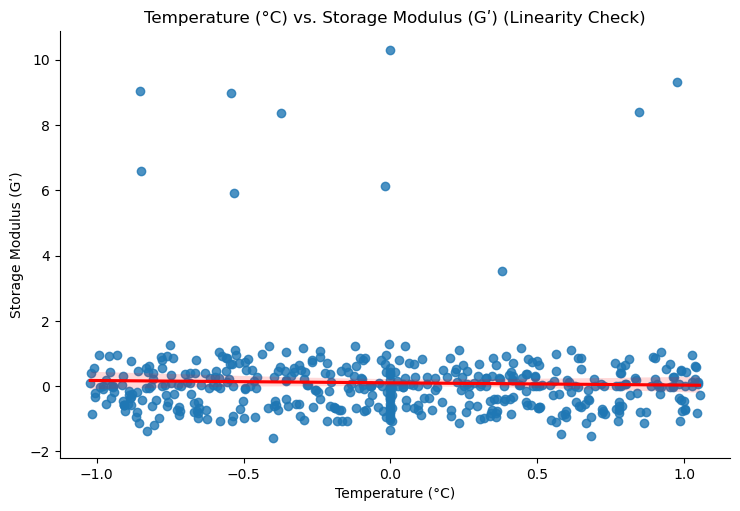

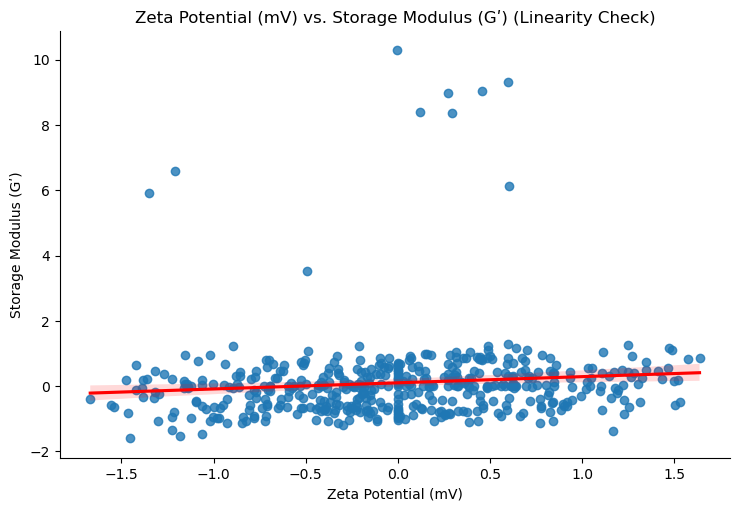

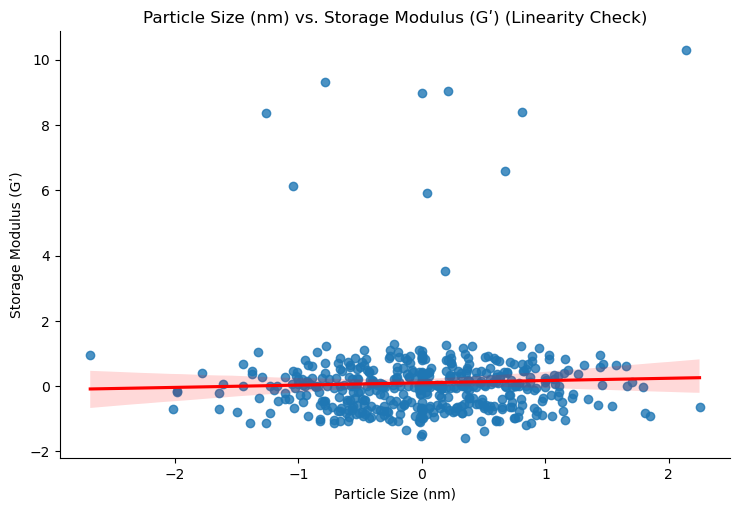

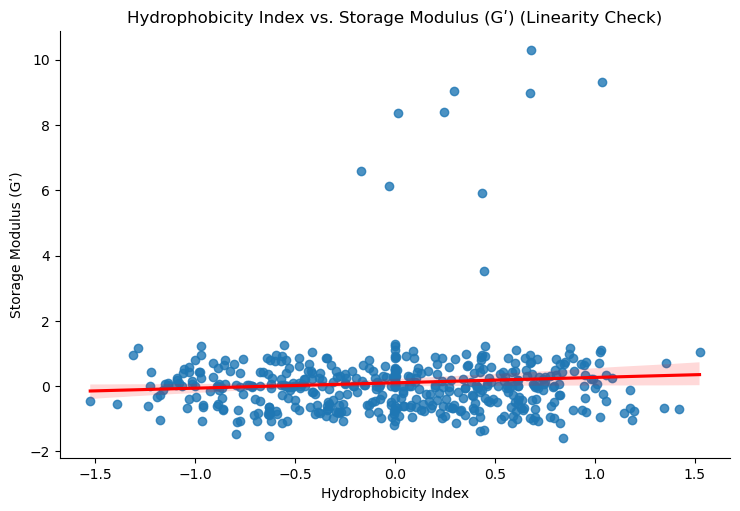

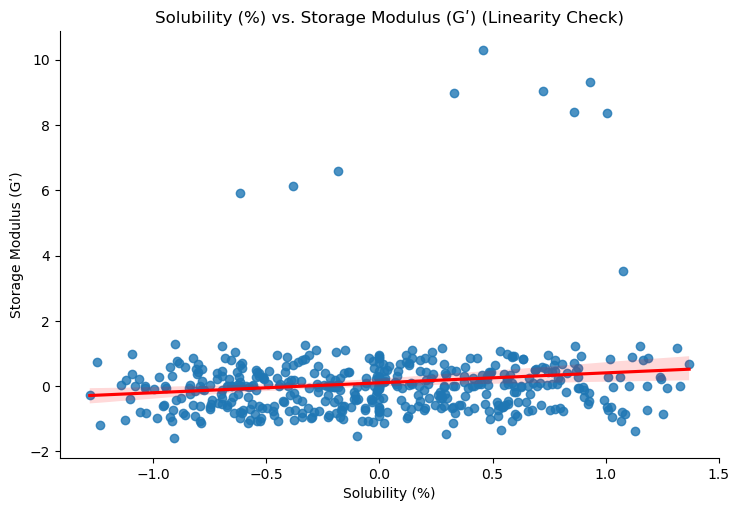

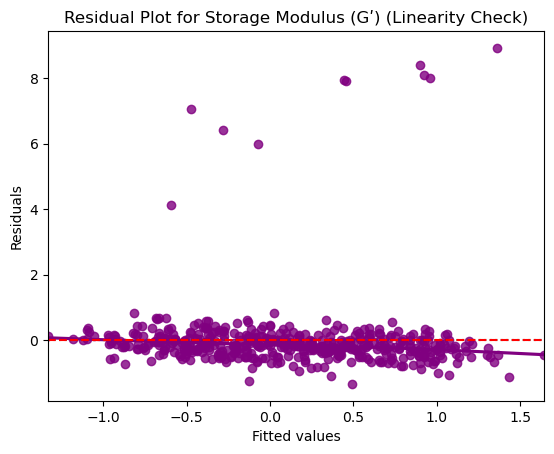

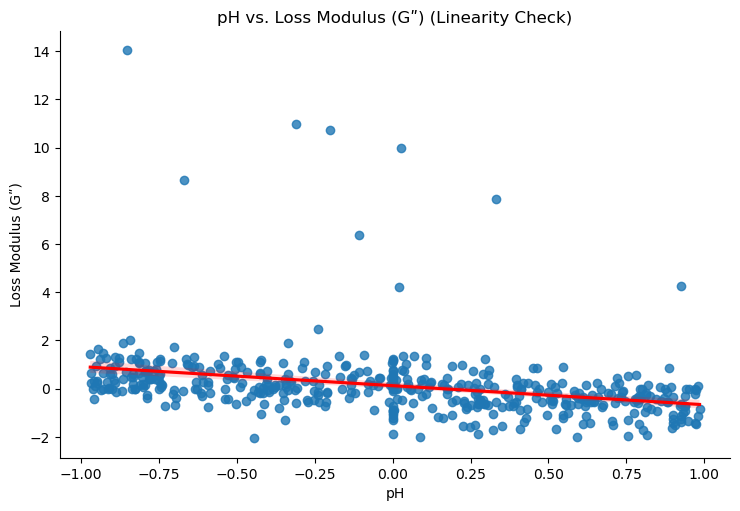

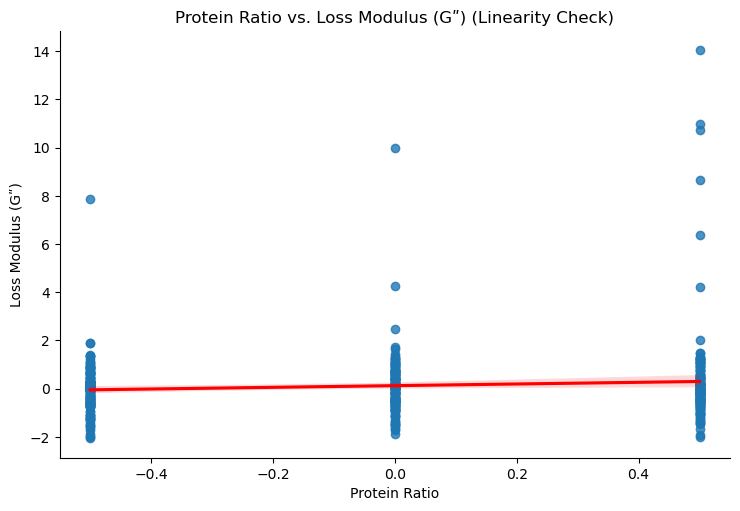

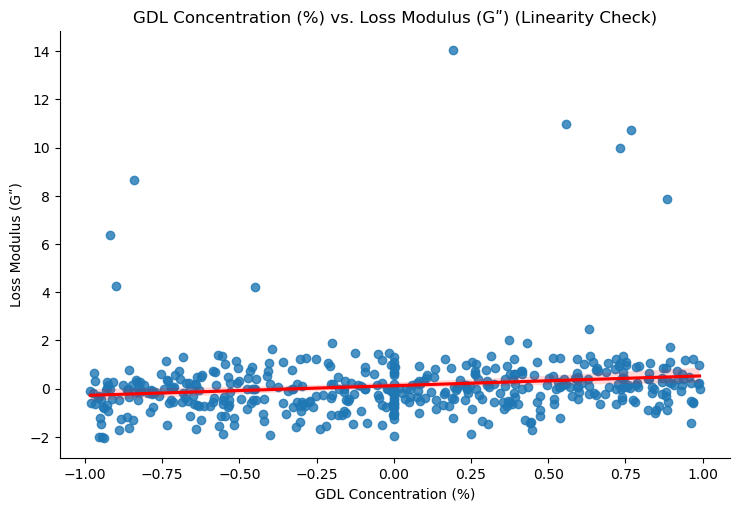

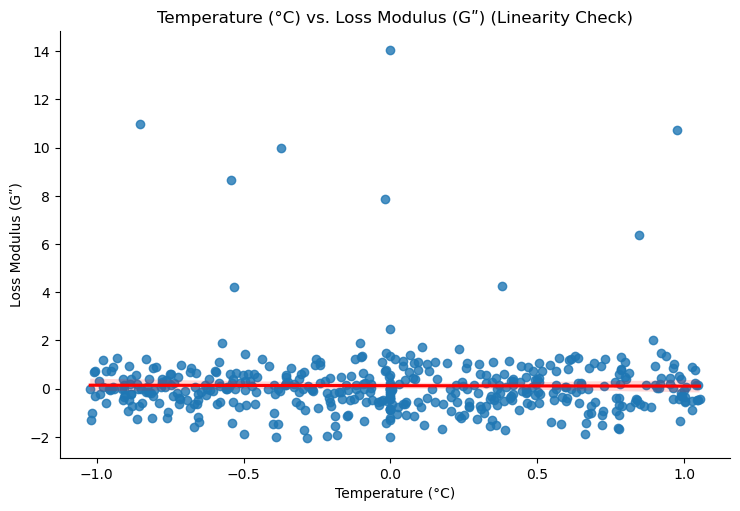

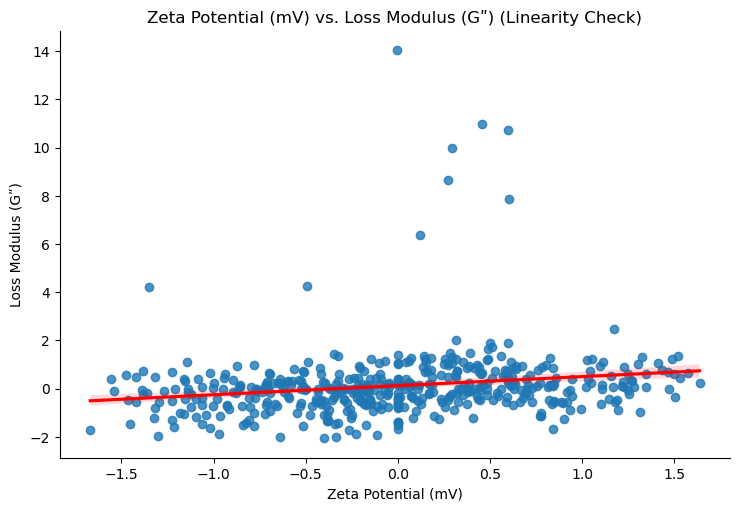

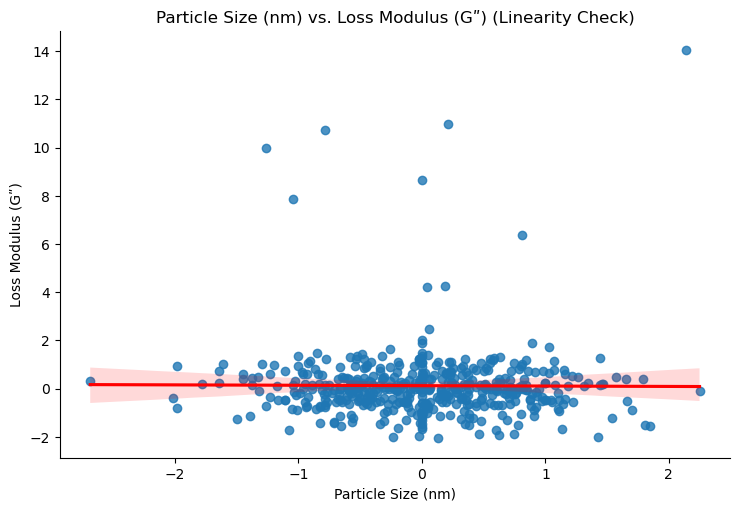

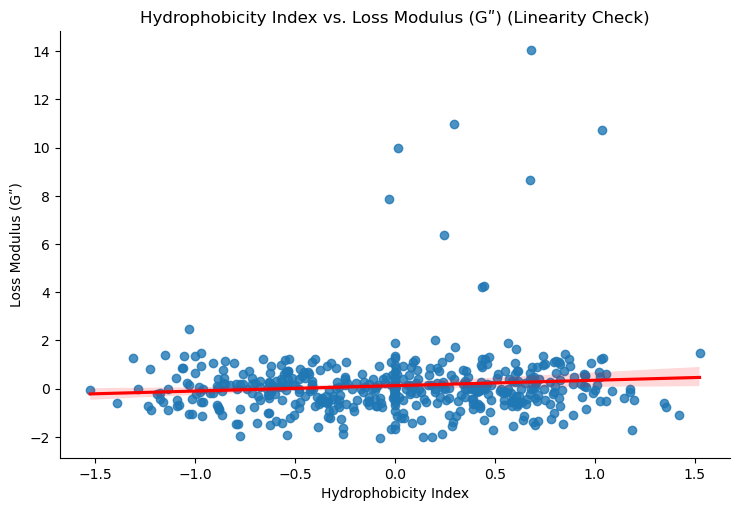

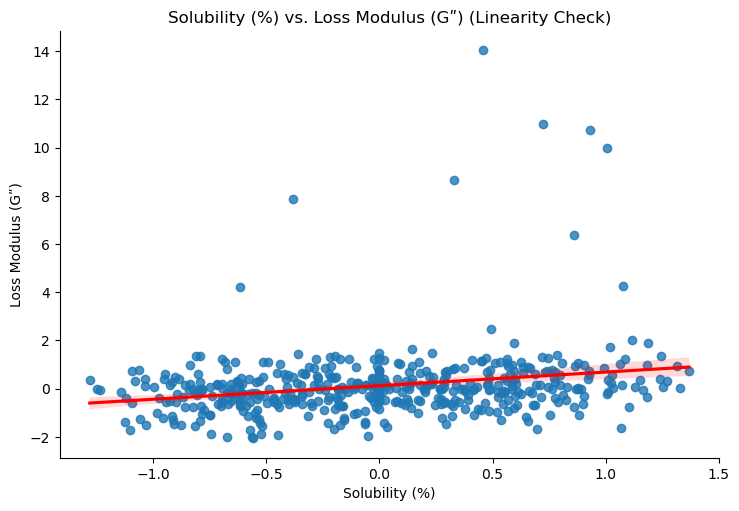

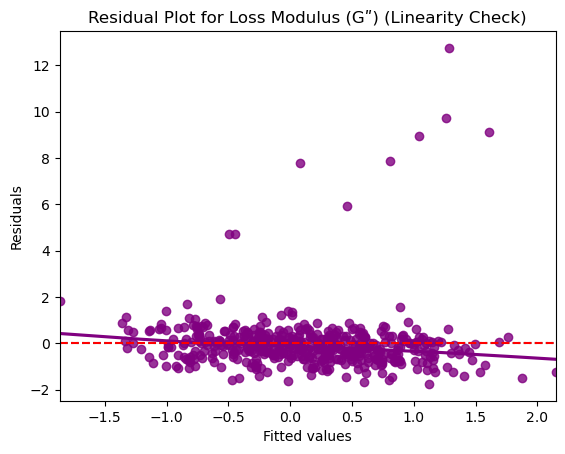

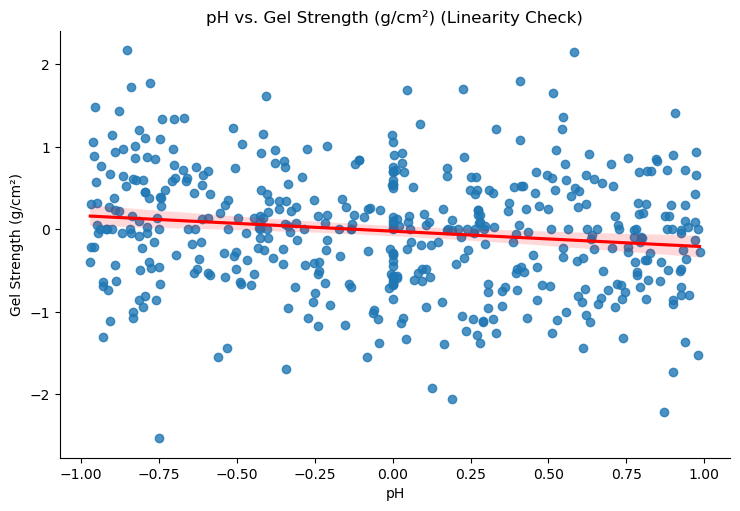

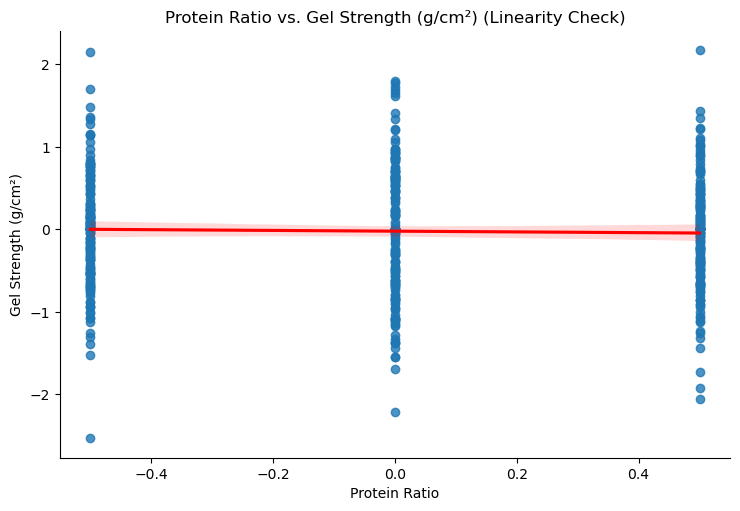

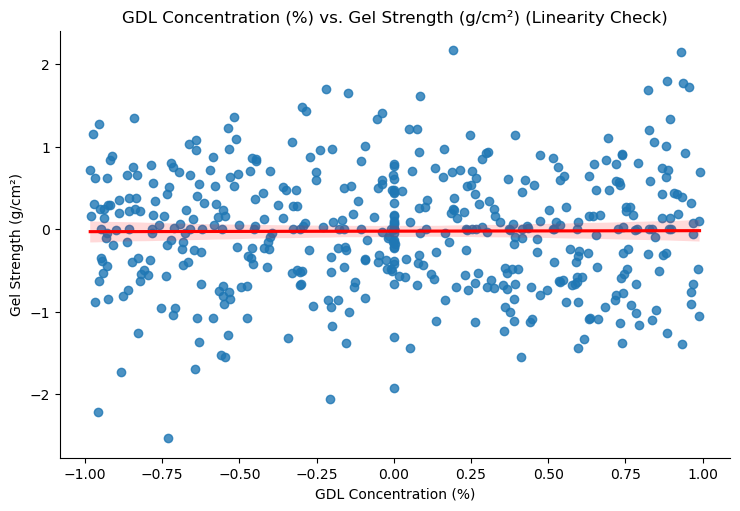

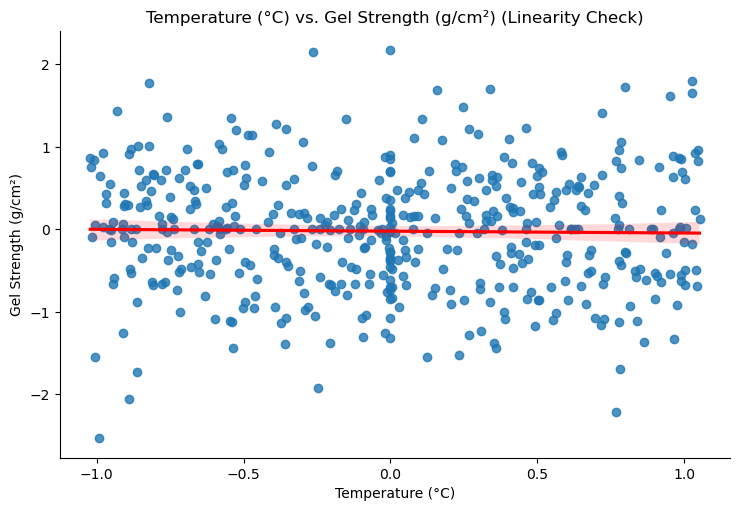

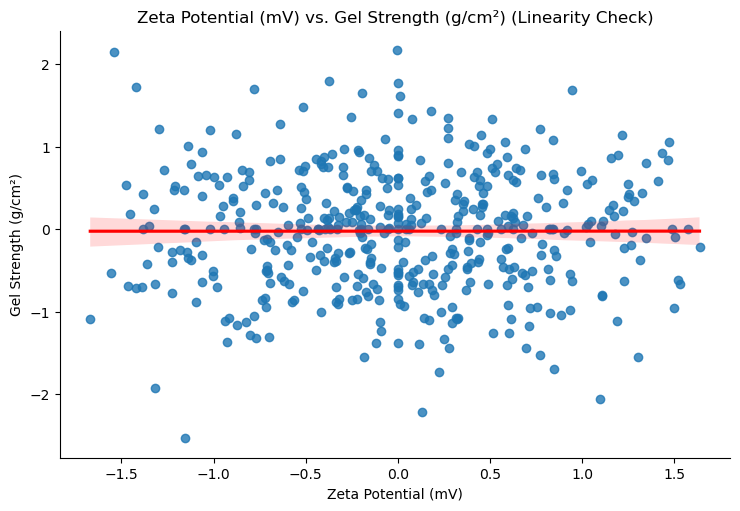

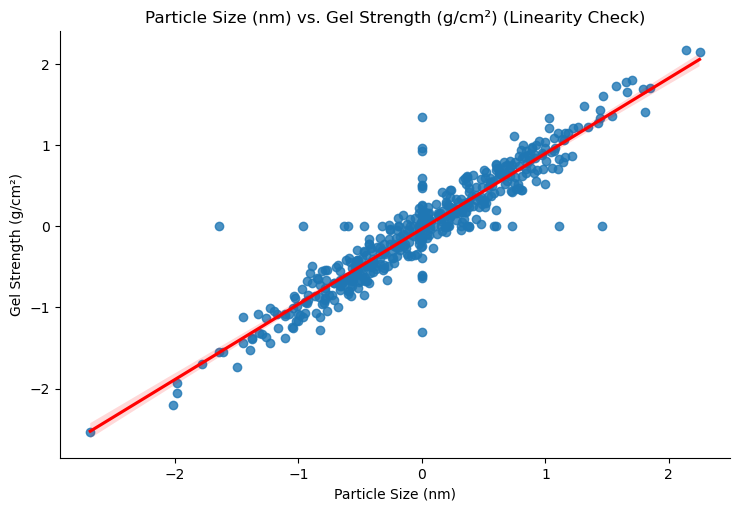

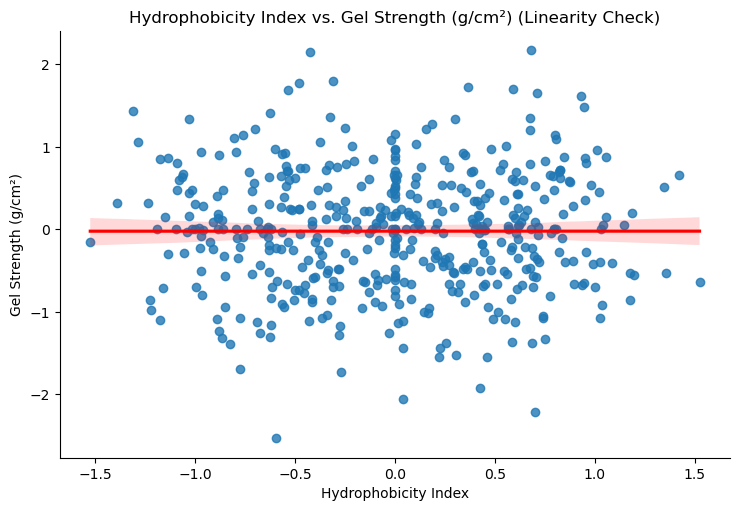

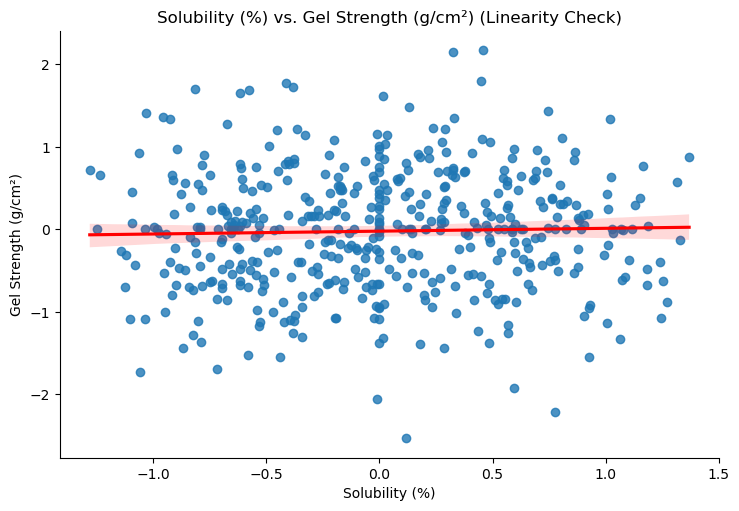

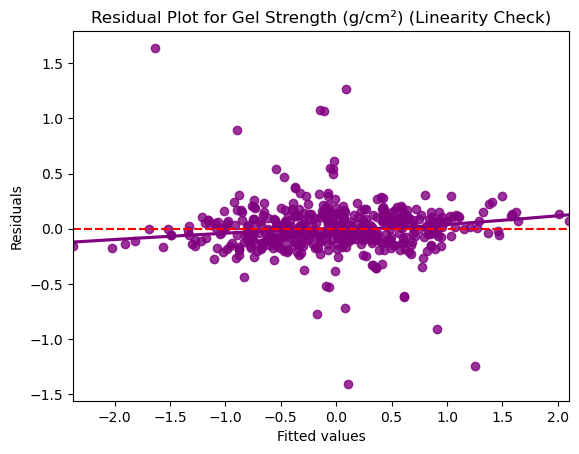

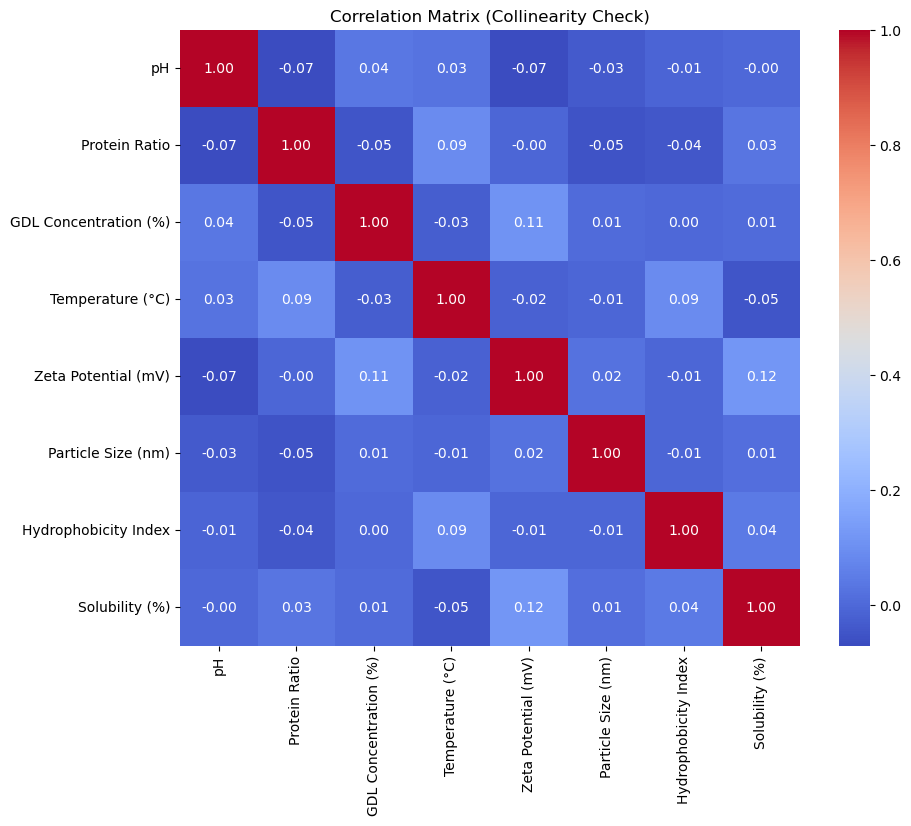


Variance Inflation Factor (VIF) for Collinearity Check:
                 Feature       VIF
0                     pH  1.014383
1          Protein Ratio  1.022796
2  GDL Concentration (%)  1.017117
3       Temperature (°C)  1.022228
4    Zeta Potential (mV)  1.033085
5     Particle Size (nm)  1.004718
6   Hydrophobicity Index  1.013954
7         Solubility (%)  1.020986


In [19]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define dependent variables and independent variable
dependent_vars = [
    'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)', 'Gel Strength (g/cm²)'
]
independent_vars = [
    'pH', 'Protein Ratio', 'GDL Concentration (%)', 'Temperature (°C)',
    'Zeta Potential (mV)', 'Particle Size (nm)', 'Hydrophobicity Index',
    'Solubility (%)'
]

# Step 1: Check Linearity
for dep in dependent_vars:
    for ind in independent_vars:
        sns.lmplot(x=ind, y=dep, data=df_multilin, aspect=1.5, line_kws={'color': 'red'})
        plt.title(f'{ind} vs. {dep} (Linearity Check)')
        plt.show()

    # Residual plots for linearity check
    X = df_multilin[independent_vars]
    X = sm.add_constant(X)
    y = df_multilin[dep]
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {dep} (Linearity Check)')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.show()

# Step 2: Check Collinearity
# Correlation matrix and heatmap
corr_matrix = df_multilin[independent_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Collinearity Check)')
plt.show()

# Variance Inflation Factor (VIF) to quantify collinearity
vif_data = pd.DataFrame()
vif_data['Feature'] = independent_vars
vif_data['VIF'] = [variance_inflation_factor(X.values, i + 1) for i in range(len(independent_vars))]
print('\nVariance Inflation Factor (VIF) for Collinearity Check:')
print(vif_data)


Conclusions regarding linearity and coll

None of the scatter plots with one exception show a clearly linear relationship as there is wide scatter and an almost flat regression line. The
Particle size vs. Gel Strength graph appears to show a linear relationship. 

As for the Residual Plots, results cluster around 0, but show significant scatter. There may be weak linear relationships. 

All Variance Inflation Factors are below 5, therefore the features do not appear to be collinear. 

This indicates that a multilinear regression may not capture all the complexity of the data, but could still be worth doing. Variable selection will be undertaken to determine if specific variables are more important than others. 

*Notes on the code that generated the samples: the nonlinearity is due to the inclusion of random noise, the combined effect of multiple different independent variables, and outliers hence a simple linear model would not be expected. 

Model 1: multilinear regression

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import f_oneway
import statsmodels.api as sm

# Step 1. Filter Methods
def filter_methods(df, dependent_variable):
    # Correlation
    X = df.drop(columns=[dependent_variable])
    y = df[dependent_variable]
    correlations = X.apply(lambda col: col.corr(y))
    print("--- Filter Methods ---")
    print("\nCorrelations with", dependent_variable, ":\n", correlations)

    # ANOVA for Protein Ratio 
    protein_ratio_groups = []
    unique_ratios = df['Protein Ratio'].unique()
    for ratio in unique_ratios:
        protein_ratio_groups.append(df[df['Protein Ratio'] == ratio][dependent_variable].values)

    # Check if there are at least two groups to perform ANOVA
    if len(protein_ratio_groups) > 1:
        fvalue, pvalue = f_oneway(*protein_ratio_groups)
        print("\nANOVA p-value for Protein Ratio:", pvalue)
    else:
        print("\nANOVA cannot be performed. Only one unique value in Protein Ratio.")

# Step 2. Embedded Methods (Lasso Regression with Alpha Refinement)
def lasso_regression_selection(df, dependent_variable, alpha_range = [0.001, 0.005, 0.01, 0.05, 0.1]):
    # Define dependent and independent variables
    X = df.drop(columns=[dependent_variable])
    y = df[dependent_variable]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Lasso model
    lasso = Lasso()

    # Set up GridSearchCV to find the best alpha
    param_grid = {'alpha': alpha_range}
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best alpha and fit the final model
    best_alpha = grid_search.best_params_['alpha']
    print("\nBest alpha from GridSearchCV:", best_alpha)

    # Fit Lasso with the best alpha
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train, y_train)

    # Get coefficients
    coefficients = lasso.coef_
    print("\n--- Lasso Regression ---")
    print("\nLasso Coefficients (alpha =", best_alpha, "):\n", coefficients)

    return coefficients, lasso

# Step 3. Model Evaluation (Lasso)
def evaluate_lasso(lasso_model, df, dependent_variable):
    # Define dependent and independent variables
    X = df.drop(columns=[dependent_variable])
    y = df[dependent_variable]

    y_pred = lasso_model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print("\n--- Lasso Evaluation ---")
    print("\nLasso R-squared:", r2)
    print("Lasso MSE:", mse)

# Step 4. Backward Elimination
def backward_elimination(df, dependent_variable, significance_level=0.05):
    # Prepare data for statsmodels
    X = df.drop(columns=[dependent_variable])
    y = df[dependent_variable]
    X = sm.add_constant(X)  # Add a constant term

    included_features = list(X.columns)
    print("\n--- Backward Elimination ---")
    while True:
        model = sm.OLS(y, X[included_features]).fit()
        pvalues = model.pvalues[1:]  # Exclude the constant's p-value
        max_pvalue = pvalues.max()
        if max_pvalue > significance_level:
            feature_to_remove = pvalues.idxmax()
            included_features.remove(feature_to_remove)
            print("\nRemoved feature:", feature_to_remove)
        else:
            break

    print("\nSelected features after backward elimination:", included_features)
    return included_features

# --- Main Execution ---
dependent_variables = ["Gel Strength (g/cm²)", "Loss Modulus (Gʺ)", "Storage Modulus (Gʹ)"]

# Define a range of alpha values to test
alpha_range = [0.001, 0.005, 0.01, 0.05, 0.1]

for dep_var in dependent_variables:
    print(f"\n=== Analyzing {dep_var} ===")
    filter_methods(df_multilin.copy(), dep_var)
    lasso_coefficients, lasso_model = lasso_regression_selection(df_multilin.copy(), dep_var, alpha_range=alpha_range)
    evaluate_lasso(lasso_model, df_multilin.copy(), dep_var)
    selected_features = backward_elimination(df_multilin.copy(), dep_var)

# Step 5. Multilinear Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

def build_multilinear_regression(df, dependent_variable, selected_features):
    # Prepare data
    X = df[selected_features]
    y = df[dependent_variable]
    
    # Add constant term
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    print(f"\n--- Multilinear Regression for {dependent_variable} ---")
    print(model.summary())
    
    # Check for multicollinearity using VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns[1:]  # Exclude constant
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data)
    
    return model

# Integrate into Main Execution
for dep_var in dependent_variables:
    print(f"\n=== Analyzing {dep_var} ===")
    filter_methods(df_multilin.copy(), dep_var)
    lasso_coefficients, lasso_model = lasso_regression_selection(df_multilin.copy(), dep_var, alpha_range=[0.01, 0.05, 0.1, 0.5, 1.0])
    evaluate_lasso(lasso_model, df_multilin.copy(), dep_var)
    selected_features = backward_elimination(df_multilin.copy(), dep_var)
    build_multilinear_regression(df_multilin.copy(), dep_var, [f for f in selected_features if f != 'const'])


=== Analyzing Gel Strength (g/cm²) ===
--- Filter Methods ---

Correlations with Gel Strength (g/cm²) :
 pH                      -0.152033
Protein Ratio           -0.025549
GDL Concentration (%)    0.004933
Temperature (°C)        -0.018322
Zeta Potential (mV)      0.000353
Particle Size (nm)       0.939879
Hydrophobicity Index     0.000156
Solubility (%)           0.028955
Storage Modulus (Gʹ)     0.110626
Loss Modulus (Gʺ)        0.045809
dtype: float64

ANOVA p-value for Protein Ratio: 0.7974035590371372

Best alpha from GridSearchCV: 0.005

--- Lasso Regression ---

Lasso Coefficients (alpha = 0.005 ):
 [-1.34852097e-01  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -2.24274611e-02  9.20612084e-01 -0.00000000e+00  3.14401929e-04
  2.02107035e-02 -0.00000000e+00]

--- Lasso Evaluation ---

Lasso R-squared: 0.8990816597558503
Lasso MSE: 0.052107655688748526

--- Backward Elimination ---

Removed feature: Hydrophobicity Index

Removed feature: Loss Modulus (Gʺ)

Removed feature: GD

Discussion of multilinear regression analysis: 



Explanation of the model:

This model aims to perform feature selection and build multilinear regression models for three dependent variables - Gel Strength, Loss Modulus, and Storage Modulus. It employs a combination of filter methods, embedded methods (Lasso regression), and backward elimination to identify the most significant predictors.

Filter methods:
Correlation: identifies the variables with linear relationships to the target.
ANOVA for protein ratio: identifies if there are significant (p < 0.05) differences between the different protein ratios.

Embedded Methods:
Lasso Regression performs feature selection by shrinking the coefficients of the less important variables. GridSearch CV helps determine the correct amount by which to shrink the coefficients. A coefficient of zero indicates that the feature has essentially been removed. 

The model evaluation determines the R^2 and mean squared error (MSE) to evaluate the degree to which the model explains the variation in the variables and the MSE indicates the average of the differences between the obtained and expected values. 

Backwards elimination: 
Uses ordinary least squares (OLS) regression to build a linear model.

P-value iteration: removes features with p values above 0.05.

Final model:
The final model is built using the selected features. 

Variance inflation factor: measures multicollinearity between variables. 


Interpretation of output:

Particle Size:
Particle size shows a very strong positive correlation (0.939879) with gel strength and is selected as a highly significant predictor. This means that particle size is the biggest determining factor of gel strength.

Lasso Feature Selection:
Lasso regression removed a lot of features, and in the case of gel strength, only particle size is retained.

Backward Elimination and Lasso:
Backward elimination and lasso select similar variables, confirming the individual results.

R^2 Values:
The R^2 values for the Lasso and multilinear regression models vary, indicating different levels of model fit.
Gel strength has a very high R^2 value, indicating that the variability is well-explained by the model.

P-values:
The p-values in the multilinear regression output indicate the statistical significance of each predictor.

VIF Values:
The VIF values are generally low and well below 5, suggesting minimal multicollinearity.


Gel Strength:
Particle size is the most significant predictor.
The multilinear regression model achieves a high R^2 (0.898).
The p-values for pH and particle size are highly significant (0.000).

Loss Modulus:
Storage Modulus and Solubility are important predictors.
R^2 is lower than for gel strength, but still fairly high.

Storage Modulus:
Loss Modulus and pH are important predictors.
R^2 is similar to the loss modulus.


Thus, the particle size is a very strong predictor of gel strength. The relationship between the variables and loss and storage moduli is more complex.
The model performs well for feature selection, and for building a multilinear regression model that explains a decent amount of the variability. 



Model 2: Neural network

In [21]:
print(df_NN_K.columns)


Index(['pH', 'Protein Ratio', 'GDL Concentration (%)', 'Temperature (°C)',
       'Zeta Potential (mV)', 'Particle Size (nm)', 'Hydrophobicity Index',
       'Solubility (%)', 'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)',
       'Gel Strength (g/cm²)'],
      dtype='object')


In [22]:
for col in ["Storage Modulus (Gʹ)", "Loss Modulus (Gʺ)"]:
    if col not in df_NN_K.columns:
        print(f"Column '{col}' not found in DataFrame!")


In [23]:
df_NN_K.rename(columns={"Storage Modulus (G')": "Storage Modulus (G')",
                   "Loss Modulus (G'')": "Loss Modulus (Gʺ)"}, inplace=True)


In [24]:
print(df_NN_K.columns.tolist())


['pH', 'Protein Ratio', 'GDL Concentration (%)', 'Temperature (°C)', 'Zeta Potential (mV)', 'Particle Size (nm)', 'Hydrophobicity Index', 'Solubility (%)', 'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)', 'Gel Strength (g/cm²)']


In [25]:
df_NN_K_nout = df_NN_K.copy()
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df_NN_K_nout_cleaned, columns):
    Q1 = df_NN_K_nout[columns].quantile(0.25)  # 25th percentile
    Q3 = df_NN_K_nout[columns].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only values within the bounds
    df_NN_K_nout_cleaned = df_NN_K_nout[(df_NN_K_nout[columns] >= lower_bound) & (df_NN_K[columns] <= upper_bound)].dropna()
    return df_NN_K_nout_cleaned

# Remove outliers from all numerical columns
df_NN_K_nout_cleaned = remove_outliers_iqr(df_NN_K, df_NN_K.columns)

# Print results
print("Original DataFrame:\n", df_NN_K_nout)
print("\nCleaned DataFrame:\n", df_NN_K_nout_cleaned)


Original DataFrame:
            pH  Protein Ratio  GDL Concentration (%)  Temperature (°C)  \
0    0.374003            0.5               0.397030          0.730688   
1    0.957232            1.0               0.050468          0.077116   
2    0.735834            0.0               0.332794          0.055720   
4    0.152806            0.0               0.000000          0.155464   
5    0.496177            0.0               0.331085          0.871661   
..        ...            ...                    ...               ...   
495  0.352555            1.0               0.546622          0.261552   
496  0.585679            0.5               0.818146          0.016094   
497  0.073563            1.0               0.450705          0.077661   
498  0.981203            1.0               0.643254          0.968271   
499  0.993163            1.0               0.525289          0.292119   

     Zeta Potential (mV)  Particle Size (nm)  Hydrophobicity Index  \
0               0.719391        

In [27]:
print(df_NN_K_nout_cleaned.corr())


                             pH  Protein Ratio  GDL Concentration (%)  \
pH                     1.000000      -0.057259               0.039771   
Protein Ratio         -0.057259       1.000000              -0.045998   
GDL Concentration (%)  0.039771      -0.045998               1.000000   
Temperature (°C)       0.023657       0.083752              -0.026476   
Zeta Potential (mV)   -0.066243      -0.023690               0.104985   
Particle Size (nm)    -0.033869      -0.059442              -0.013218   
Hydrophobicity Index  -0.007374      -0.066458               0.009491   
Solubility (%)        -0.001053       0.014478               0.004158   
Storage Modulus (Gʹ)  -0.855531       0.028753               0.087478   
Loss Modulus (Gʺ)     -0.537799       0.010414               0.241030   
Gel Strength (g/cm²)  -0.153041      -0.038634              -0.008454   

                       Temperature (°C)  Zeta Potential (mV)  \
pH                             0.023657            -0.06624

Available columns in df_NN_K_nout_cleaned: ['pH', 'Protein Ratio', 'GDL Concentration (%)', 'Temperature (°C)', 'Zeta Potential (mV)', 'Particle Size (nm)', 'Hydrophobicity Index', 'Solubility (%)', 'Storage Modulus (Gʹ)', 'Loss Modulus (Gʺ)', 'Gel Strength (g/cm²)']


C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.6732 - mae: 0.5910 - val_loss: 0.3817 - val_mae: 0.4574 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3378 - mae: 0.3659 - val_loss: 0.3237 - val_mae: 0.3876 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2356 - mae: 0.2313 - val_loss: 0.2598 - val_mae: 0.3061 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1977 - mae: 0.1664 - val_loss: 0.2237 - val_mae: 0.2442 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1835 - mae: 0.1446 - val_loss: 0.2055 - val_mae: 0.2084 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1797 - mae: 0.1339 - val_loss: 0.1928 - val_mae: 0.1831 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1743 - mae: 0.1273 - val_loss: 0.1860 - val_mae: 0.1703 - learning_rate: 0.0020
Epoch 8/150


C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.0255 - mae: 1.1300 - val_loss: 0.4012 - val_mae: 0.4745 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1047 - mae: 0.8837 - val_loss: 0.3378 - val_mae: 0.4030 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7004 - mae: 0.6736 - val_loss: 0.2805 - val_mae: 0.3197 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4334 - mae: 0.4526 - val_loss: 0.2335 - val_mae: 0.2371 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3252 - mae: 0.3426 - val_loss: 0.2061 - val_mae: 0.1816 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2406 - mae: 0.2398 - val_loss: 0.1878 - val_mae: 0.1478 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2165 - mae: 0.1969 - val_loss: 0.1784 - val_mae: 0.1307 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.6038 - mae: 0.5039 - val_loss: 0.3801 - val_mae: 0.4636 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3123 - mae: 0.2901 - val_loss: 0.3262 - val_mae: 0.3940 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2097 - mae: 0.1889 - val_loss: 0.2867 - val_mae: 0.3403 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1990 - mae: 0.1670 - val_loss: 0.2607 - val_mae: 0.3035 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1961 - mae: 0.1609 - val_loss: 0.2426 - val_mae: 0.2747 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1759 - mae: 0.1257 - val_loss: 0.2235 - val_mae: 0.2403 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1750 - mae: 0.1249 - val_loss: 0.2079 - val_mae: 0.2119 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.9416 - mae: 0.6080 - val_loss: 0.4552 - val_mae: 0.5308 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3248 - mae: 0.3215 - val_loss: 0.4719 - val_mae: 0.5442 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2418 - mae: 0.2215 - val_loss: 0.4697 - val_mae: 0.5385 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2276 - mae: 0.2078 - val_loss: 0.4276 - val_mae: 0.5015 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2111 - mae: 0.1747 - val_loss: 0.3714 - val_mae: 0.4468 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1956 - mae: 0.1608 - val_loss: 0.3359 - val_mae: 0.4065 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2006 - mae: 0.1577 - val_loss: 0.3072 - val_mae: 0.3729 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.8473 - mae: 1.1079 - val_loss: 0.4103 - val_mae: 0.4937 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0749 - mae: 0.8769 - val_loss: 0.3688 - val_mae: 0.4469 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6831 - mae: 0.6578 - val_loss: 0.3151 - val_mae: 0.3811 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4349 - mae: 0.4735 - val_loss: 0.2605 - val_mae: 0.3081 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3225 - mae: 0.3356 - val_loss: 0.2245 - val_mae: 0.2445 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2489 - mae: 0.2516 - val_loss: 0.2026 - val_mae: 0.1953 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2091 - mae: 0.1829 - val_loss: 0.1915 - val_mae: 0.1651 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.5638 - mae: 1.0294 - val_loss: 0.4318 - val_mae: 0.5053 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9272 - mae: 0.8219 - val_loss: 0.3852 - val_mae: 0.4555 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5998 - mae: 0.6100 - val_loss: 0.3427 - val_mae: 0.4019 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3903 - mae: 0.4374 - val_loss: 0.3008 - val_mae: 0.3428 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2858 - mae: 0.3124 - val_loss: 0.2637 - val_mae: 0.2861 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2383 - mae: 0.2361 - val_loss: 0.2369 - val_mae: 0.2451 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1960 - mae: 0.1702 - val_loss: 0.2171 - val_mae: 0.2140 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.6821 - mae: 0.5615 - val_loss: 0.4592 - val_mae: 0.5364 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2822 - mae: 0.2597 - val_loss: 0.4546 - val_mae: 0.5256 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2383 - mae: 0.2291 - val_loss: 0.4208 - val_mae: 0.4943 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2091 - mae: 0.1805 - val_loss: 0.3691 - val_mae: 0.4424 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1893 - mae: 0.1509 - val_loss: 0.3198 - val_mae: 0.3837 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1873 - mae: 0.1481 - val_loss: 0.2869 - val_mae: 0.3430 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1768 - mae: 0.1216 - val_loss: 0.2605 - val_mae: 0.3051 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.5897 - mae: 0.5087 - val_loss: 0.4747 - val_mae: 0.5548 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3066 - mae: 0.2921 - val_loss: 0.4951 - val_mae: 0.5784 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2745 - mae: 0.2610 - val_loss: 0.4655 - val_mae: 0.5512 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2300 - mae: 0.2265 - val_loss: 0.4128 - val_mae: 0.5035 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1949 - mae: 0.1713 - val_loss: 0.3648 - val_mae: 0.4562 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1910 - mae: 0.1539 - val_loss: 0.3250 - val_mae: 0.4096 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1887 - mae: 0.1522 - val_loss: 0.2926 - val_mae: 0.3689 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.8808 - mae: 1.1603 - val_loss: 0.3976 - val_mae: 0.4768 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1890 - mae: 0.9064 - val_loss: 0.3409 - val_mae: 0.3992 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6907 - mae: 0.6745 - val_loss: 0.2992 - val_mae: 0.3325 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4753 - mae: 0.5106 - val_loss: 0.2623 - val_mae: 0.2764 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3242 - mae: 0.3597 - val_loss: 0.2311 - val_mae: 0.2216 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2522 - mae: 0.2589 - val_loss: 0.2137 - val_mae: 0.1888 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2177 - mae: 0.2118 - val_loss: 0.2027 - val_mae: 0.1745 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\envs\py3TF2\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 1.4299 - mae: 0.9570 - val_loss: 0.4219 - val_mae: 0.4979 - learning_rate: 0.0020
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7750 - mae: 0.6972 - val_loss: 0.3930 - val_mae: 0.4645 - learning_rate: 0.0020
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4433 - mae: 0.4743 - val_loss: 0.3544 - val_mae: 0.4227 - learning_rate: 0.0020
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3042 - mae: 0.3287 - val_loss: 0.3067 - val_mae: 0.3655 - learning_rate: 0.0020
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2414 - mae: 0.2367 - val_loss: 0.2633 - val_mae: 0.3030 - learning_rate: 0.0020
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2171 - mae: 0.1966 - val_loss: 0.2300 - val_mae: 0.2453 - learning_rate: 0.0020
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2071 - mae: 0.1781 - val_loss: 0.2128 - val_mae: 0.2129 - learning_rate: 0.0020
Epoch 8/150
11/11 ━━━━━━

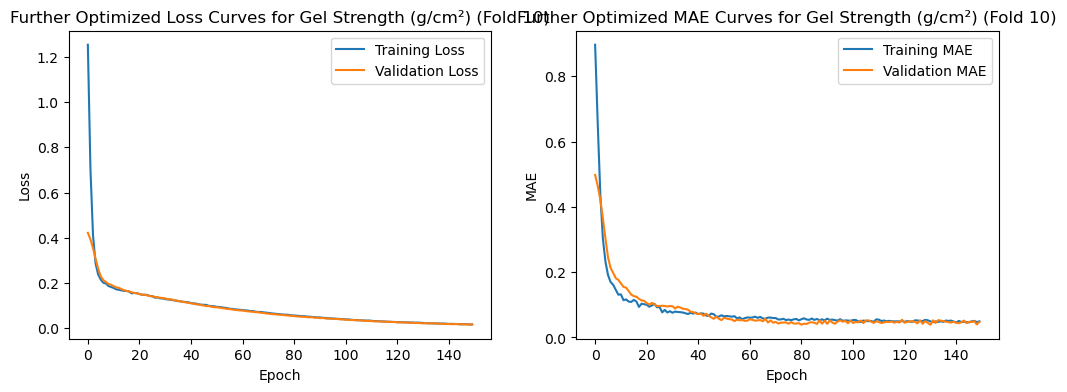

In [26]:
#Gel Strength
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Define feature set for Gel Strength
features = ['pH', 'Particle Size (nm)']
dependent_variable = "Gel Strength (g/cm²)"

# Debug: Check if dependent variable exists
print(f"Available columns in df_NN_K_nout_cleaned: {df_NN_K_nout_cleaned.columns.tolist()}")
if dependent_variable not in df_NN_K_nout_cleaned.columns:
    print(f"Error: {dependent_variable} not found in DataFrame.")
else:
    # Prepare data
    X = df_NN_K_nout_cleaned[features].values
    y = df_NN_K_nout_cleaned[dependent_variable].values

    # Robust scaling
    scaler = RobustScaler()
    X = scaler.fit_transform(X)

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Convert to tensors
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        # Build optimized model
        model = Sequential()
        n_features = len(features)

        model.add(Dense(128, input_shape=(n_features,), kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))  
        model.add(Dropout(0.15))  

        model.add(Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.15))

        model.add(Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.1))  

        model.add(Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Added one extra layer
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))

        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=0.002)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        # Create datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
        val_split = 0.2
        val_size = int(len(X_train) * val_split)
        train_size = len(X_train) - val_size
        val_dataset = tf.data.Dataset.from_tensor_slices((X_train[val_size:], y_train[val_size:])).batch(32).prefetch(tf.data.AUTOTUNE)
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train[:train_size], y_train[:train_size])).batch(32).prefetch(tf.data.AUTOTUNE)

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

        # Train model
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=150,
                           callbacks=[early_stopping, reduce_lr], verbose=1)

        # Evaluate
        y_pred = model.predict(X_test)
        y_test_np = y_test.numpy()
        y_pred_np = y_pred.squeeze()

        r2 = r2_score(y_test_np, y_pred_np)
        mse = mean_squared_error(y_test_np, y_pred_np)
        r2_scores.append(r2)
        mse_scores.append(mse)

        print(f"\nFold {fold + 1} - Test R-squared: {r2:.4f}, Test MSE: {mse:.4f}")

    # Average scores
    mean_r2 = np.mean(r2_scores) if r2_scores else float('nan')
    mean_mse = np.mean(mse_scores) if mse_scores else float('nan')
    std_r2 = np.std(r2_scores) if r2_scores else float('nan')
    std_mse = np.std(mse_scores) if mse_scores else float('nan')

    print(f"\n--- Further Optimized Neural Network Results for {dependent_variable} (10-Fold CV) ---")
    print(f"Mean Test R-squared: {mean_r2:.4f} (±{std_r2:.4f})")
    print(f"Mean Test MSE: {mean_mse:.4f} (±{std_mse:.4f})")
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Further Optimized Loss Curves for {dependent_variable} (Fold {fold + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'Further Optimized MAE Curves for {dependent_variable} (Fold {fold + 1})')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()


The neural network analysis required considerable reworking to obtain an acceptable result. The dataset had to be cleaned of outliers and a large number of hyperparameters changed and fine-tuned. The model explains the variation in gel strength quite well (R^2 = 0.82), but models for storage and loss moduli did not perform well and consistently achieved R^2s of approximately -0.0 despite many iterations and modifications. These models are not included here as they do not provide any value for intepreting the data. As with the mutlinear regression model, the gel strength is the easiest to model. As for why the moduli models did not work, it is likely that the dataset was too small, at only 458 rows. Neural networks generally require much larger datasets (REF). While this could be easily adressed in this case due to the use of simulated data, computing capacity is limited. Thus, in further study, using a sufficiently large dataset for neural networks is paramount. 

The training loss is similar to the validation loss, which indicates that the model is performing quite well and neither under nor overfitting. 

Model 3: K-means clustering

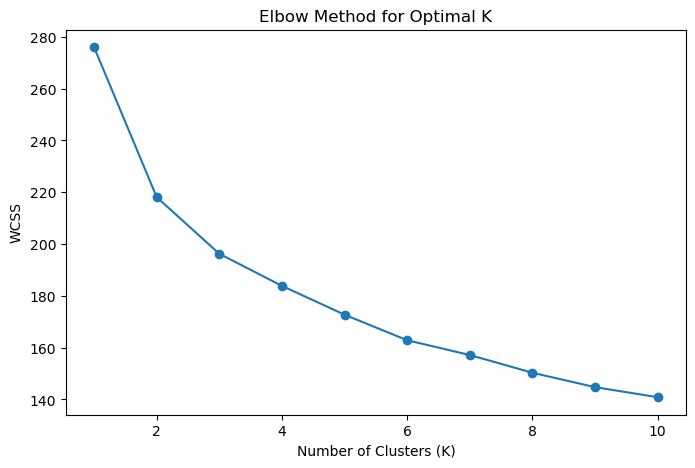

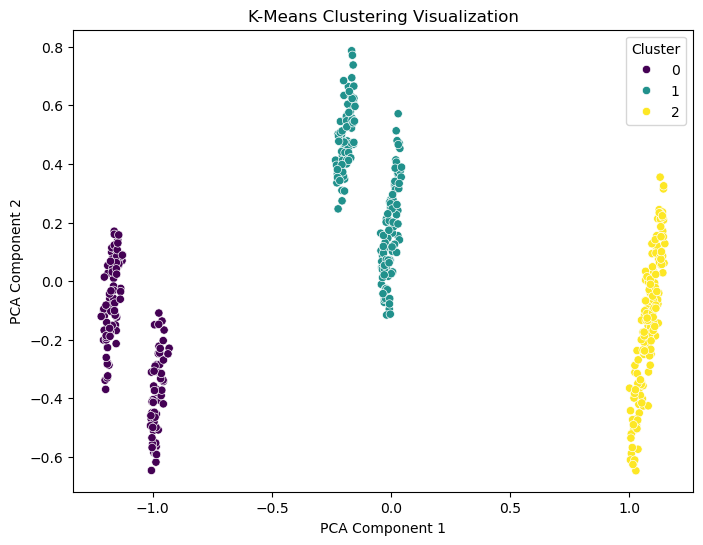

               pH  Protein Ratio  GDL Concentration (%)  Temperature (°C)  \
Cluster                                                                     
0        0.210110       0.785714               0.473941          0.476691   
1        0.721846       0.716463               0.521417          0.550215   
2        0.519422       0.000000               0.497666          0.451303   

         Zeta Potential (mV)  Particle Size (nm)  Hydrophobicity Index  \
Cluster                                                                  
0                   0.525185            0.559607              0.498577   
1                   0.478055            0.530509              0.484178   
2                   0.517479            0.555800              0.513368   

         Solubility (%)  Storage Modulus (Gʹ)  Loss Modulus (Gʺ)  \
Cluster                                                            
0              0.464893              0.170216           0.148958   
1              0.491824              0.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = df_NN_K_nout_cleaned.copy()


# Find optimal K using the Elbow Method
wcss = []  # Within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to determine the best K
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()

# Choose the optimal number of clusters (assume 3 based on the elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df["Cluster"], palette="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()

# Display cluster means
cluster_means = df.groupby("Cluster").mean()
print(cluster_means)


Interpretation of clustering model:

Due to scaling of the data, the units are not original. Thus, only the relative contribution of each component is apparent. In the following table, the three clusters are compared, with "H" = highest value, "M" = middle value, and "L" = lowest value. 


| Cluster # | Casein % | pH  | GDL Concentration | Temperature | Zeta Potential | Particle Size | Hydrophobicity Index | Solubility | Gʹ  | Gʺ  | Gel Strength |
|-----------|----------|-----|------------------|------------|---------------|--------------|-------------------|-----------|----|----|--------------|
| 0         | 80       | L   | L                | M          | H             | H            | M                 | L         | H  | H  | H            |
| 1         | 50       | H   | H                | H          | L             | L            | L                 | H         | L  | L  | L            |
| 2         | 20       | M   | M                | L          | M             | M            | H                 | M         | M  | M  | M            |


The results are discussed as if it were real-life data. As this is not the case, a brief explanation of the code follows this discussion.

Cluster-by-Cluster Analysis:

Cluster 0 (80% casein) 
This cluster exhibited the highest storage modulus (G'), loss modulus (G''), and gel strength, indicating the formation of the strongest and most elastic gel network. These high rheological properties are consistent with the known gel-forming capabilities of casein, the gel-forming properties being one of the most important aspects of the use of caseins for applications such as cheese and yoghurt. However, Cluster 0 also showed the lowest pH and GDL concentration, which is counterintuitive as pH and [GDL] should be negatively correlated. There is a complex relationship between pH and particle size of sodium caseinate gels where at higher pHs (well above the pI), the aggregates may be smaller while closer to the pI the particles may be larger. At pH values well below the pI, the particles may decrease in size again (Ghorbani Gorji et al., 2015). In micellar casein gels, a smaller particle size generally allows for the formation of stronger gels (Glantz et al., 2010). More investigation into the relationship between rheology and particle size in this system is warranted as that could be a useful property to manipulate to obtain desirable rheological properties. 

Cluster 1 (50% Casein): 
This cluster was characterized by the highest solubility but the lowest storage modulus, loss modulus, and gel strength. The inverse relationship between solubility and rheological properties is curious to note as one could expect a more soluble protein to have better access to the acidulant and therefore likely form a stronger network. The relationship between the other variables and solubility could be of interest to explore further as pH, zeta-potential, temperature, and other factors will all have marked effects on the solubility. One potential explanation for the more soluble samples having lower values of rheological properties, is that high solubility might indicate a less structured gel network, hindering protein-protein interactions necessary for gel strength. However, previous work on this topic makes it clear that there is considerable variation between studies and that the solubility of the protein can affect the gel strength at different pHs (Khalesi et al., 2024). Thus, the relationship between pH, solubility, and gel proprieties in this particular system should be further studied. Also, this cluster had the highest pH, and GDL concentration, which as stated before, is counter intuitive.

Cluster 2 (20% Casein): 
This cluster displayed moderate values for most properties. Interestingly, it exhibited higher gel strength than Cluster 1 (50% casein), suggesting a nonlinear relationship between protein ratio and gel strength. This might be due to preferential coagulation of proteins with the same type, where high concentrations of either casein or pea protein lead to stronger self-interactions. Indeed, previous studies have found that in gel blends of soy protein and whey protein, the protein at the higher concentration does indeed form a continuous gel network (Khalesi et al., 2024). The differing isoelectric points of casein and pea protein may also contribute to this phenomenon.

Subclusters and Further Investigation:
The presence of subclusters within Clusters 0 and 1 indicates that the first two principal components might not capture all the variability in the data. Further analysis using additional principal components or alternative clustering algorithms, such as hierarchical clustering or DBSCAN, could reveal a more detailed cluster structure.

Elbow Method and Cluster Validation:
The elbow method suggested that a higher number of clusters might be appropriate, as the WCSS continued to decrease significantly beyond three clusters. However, the elbow method is a heuristic and should be complemented with other cluster validation metrics, such as the silhouette score, to determine the optimal number of clusters.

Conclusion:
The K-means clustering analysis, visualized through PCA, revealed three distinct clusters based on the physicochemical properties of protein gels. The most significant differentiating factor appears to be the casein: pea protein ratio, which influences the rheological properties. The clustering analysis provided valuable insights into the relationships between protein gel properties and processing parameters. The nonlinear relationship between protein ratio and gel strength, as well as the unexpected relationships between solubility and rheological properties, warrant further investigation. The relationship between the protein ratio and rheological properties is of particular interest as this could provide insight into the mechanism of interaction between the proteins as well as provide useful information on how to manipulate the protein ratio for particular purposes. The analysis also highlighted potential limitations in the K-means algorithm's ability to capture finer substructures, as evidenced by subclusters within the main clusters.

** Explanation according to code for the data: The code used to generate the dataset simulates the independent variables (pH, protein ratio, GDL concentration, temperature) using random uniform or random choice distributions. This means that there is no inherent correlation between these variables, which might not reflect real-world scenarios. For example, the code generates pH and GDL concentration independently, whereas in a real experiment, they would likely be negatively correlated (higher GDL concentration leads to lower pH).

The dependent variables (rheological properties) are then simulated as linear combinations of the independent variables, with added noise to mimic experimental variability. This approach might have influenced the clustering results, as the K-means algorithm would have identified patterns based on these simulated relationships.

The code also introduces missing values and outliers to simulate real-world dataset imperfections. These imperfections were removed before analysis.

Therefore, the clustering results should be interpreted with caution, as they are based on simulated data. Further validation with real-world experimental data is necessary to confirm the observed patterns.




Future work:

This project will continue to undergo refinements. These planned improvements include:

Elaborating on explanations of the code and the results. In particular, the choices made for the neural network model require more explanation.

Expanding the literature review to provide a more comprehensive scientific background to the study. In particular, explaining why the variables used were chosen, how they generally affect real-life gels, and the implications for product development. 

Attempt to increase the dataset size in order to build neural networks for storage and loss moduli. 

Further refine the models by changing hyperparameters and incorporating new techniques. 